Практическое задание 3: Одномерный анализ данных для улучшения
качества данных

# 0. Установка зависимостей и загрузка данных

Душкина А.А.

....

В используемом датасете содержится информация о потреблении энергии и воды в Нью-Йорке.

Краткое описание используемых переменных:

Property Id - Номер, присвоенный каждой заявке на бенчмаркинг. Это значение уникально для каждой записи, представленной в поле BBL. Если Департамент финансов не получил заявку на бенчмаркинг, то в соответствующей колонке не будет присвоенного номера записи

BBL - 10 digits - 10-значный идентификатор недвижимости, состоящий из округа, блока и участка

Postal Code - Почтовый ZIP-код недвижимости, указанный самостоятельно

Self-Reported Gross Floor Area (ft²) - Варианты типов недвижимости

Year Built - Год постройки недвижимости

Number of Buildings - Количество зданий указывает общее число зданий, расположенных на налоговом участке

Occupancy - Процент общей площади (GFA) вашей недвижимости, которая занята и функционирует

ENERGY STAR Score - Рейтинг от 1 до 100 для определённых типов зданий

Source EUI (kBtu/ft²) - Интенсивность потребления энергии, выраженная в кБту на квадратный фут общей площади за отчётный год

Weather Normalized Source EUI (kBtu/ft²) - Интенсивность потребления энергии, выраженная в кБту на квадратный фут общей площади за отчётный год, с учетом нормализации по погодным условиям

Site EUI (kBtu/ft²) - Интенсивность потребления энергии, выраженная в кБту на квадратный фут общей площади за отчётный год

Weather Normalized Site EUI (kBtu/ft²) - Интенсивность потребления энергии, выраженная в кБту на квадратный фут общей площади за отчётный год, с учетом нормализации по погодным условиям

Weather Normalized Site Electricity Intensity (kWh/ft²) - Нормализованное по погодным условиям потребление энергии на объекте, делённое на размер недвижимости или на поток через водо- или водоотводное очистное сооружение.

Weather Normalized Site Natural Gas Intensity (therms/ft²) - Нормализованное по погодным условиям потребление энергии на объекте, делённое на размер недвижимости или на поток через водо- или водоотводное очистное сооружение.

Детальнее про прочие переменные см., пожауйлста, в пдф файле

In [35]:
# Скачиваем необоходимые библиотеки
import pandas as pd
import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

In [36]:
def scores(reg, X_train, y_train, X_test, y_test):
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    metrics = pd.DataFrame(
        [[mean_absolute_error(y_train, pred_train),
          mean_absolute_error(y_test, pred_test)],
         [mean_squared_error(y_train, pred_train),
          mean_squared_error(y_test, pred_test)],
          [np.sqrt(mean_squared_error(y_train, pred_train)),
          np.sqrt(mean_squared_error(y_test, pred_test))],
         [r2_score(y_train, pred_train),
          r2_score(y_test, pred_test)]],
        columns=['Train', 'Test'],
        index=['MAE', 'MSE', 'RMSE', 'R2'])
    return metrics

In [37]:
pd.options.display.float_format = '{:.3f}'.format

In [38]:
# !pip install wget --quiet

In [39]:
'''
from wget import download

download('https://drive.google.com/uc?export=download&id=15y6HTXE0cgGgTAV0r3cxY09hsJhAevOs',
         '/content/nyc_benchmarking_disclosure_2017_consumption_data.xlsx')'''

"\nfrom wget import download\n\ndownload('https://drive.google.com/uc?export=download&id=15y6HTXE0cgGgTAV0r3cxY09hsJhAevOs',\n         '/content/nyc_benchmarking_disclosure_2017_consumption_data.xlsx')"

In [40]:
#pip install openpyxl

In [41]:
# Скачиваем датасет
df = pd.read_excel('nyc_benchmarking_disclosure_2017_consumption_data.xlsx', sheet_name=1)

# 1. Описательные признаки по данным

In [42]:
# Просмотр переменных
df.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2 (self-reported),...,Annual Maximum Demand (kW),Annual Maximum Demand (MM/YYYY),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Water Required?,Generation Date,DOF Benchmarking Submission Status
0,1,4593574,The Argonaut Building,NaN,NaN,1010287502.000,1010287502,1024898,224 West 57th St,NaN,...,NaN,NaT,732.400,76.300,656.100,3635.500,21.460,Not found,2018-02-14,Not found
1,3,2967701,Cathedral Preparatory Seminary,NaN,NaN,4018720007.000,4-01872-0007,4046340,56-25 92nd Street,NaN,...,NaN,NaT,164.500,109.900,54.600,102.900,1.090,Not found,2018-02-14,Not found
2,4,4898531,The Nomad Hotel,NaN,NaN,1008290050.000,1-00829-0050,1080710,1170 Broadway,NaN,...,NaN,NaT,1150.200,438.000,712.300,10762.600,86.100,Not found,2018-02-14,Not found
3,5,2917939,10 West 27 Street Corp,NaN,NaN,1008280053.000,1-00828-0053,1015657,1155 Broadway,NaN,...,NaN,NaT,273.400,98.200,175.300,790.100,15.800,Not found,2018-02-14,Not found
4,6,3878205,Westbury Realty,NaN,NaN,1000650024.000,1-00065-0024,1001105,24 John Street,NaN,...,NaN,NaT,90.700,0.000,90.700,143.000,2.860,Not found,2018-02-14,Not found


In [43]:
# В таблице 34355 строки и 60 столбцов
print(df.shape)

(34355, 60)


In [44]:
# Названия столбцов
print(df.columns)

Index(['Order', 'Property Id', 'Property Name', 'Parent Property Id',
       'Parent Property Name', 'BBL - 10 digits',
       'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Address 2 (self-reported)', 'Postal Code', 'Street Number',
       'Street Name', 'Borough', 'DOF Gross Floor Area (ft²)',
       'Self-Reported Gross Floor Area (ft²)',
       'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings', 'Occupancy', 'Metered Areas (Energy)',
       'Metered Areas  (Water)', 'ENERGY STAR Score', 'Source EUI (kBtu/ft²)',


In [45]:
# Общ инфа
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34355 entries, 0 to 34354
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Order                                                       34355 non-null  int64         
 1   Property Id                                                 34355 non-null  int64         
 2   Property Name                                               34355 non-null  object        
 3   Parent Property Id                                          1723 non-null   object        
 4   Parent Property Name                                        1723 non-null   object        
 5   BBL - 10 digits                                             33625 non-null  float64       
 6   NYC Borough, Block and Lot (BBL) self-reported              33626 non-null  object        
 7   NYC Building Identific

In [46]:
# Статистика по нечисловым признакам
df.describe(include=['object', 'bool'])

,Property Name,Parent Property Id,Parent Property Name,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2 (self-reported),Postal Code,Street Number,Street Name,...,DOF Gross Floor Area (ft²),Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,3rd Largest Property Use Type,Metered Areas (Energy),Metered Areas (Water),Water Required?,DOF Benchmarking Submission Status
count,34355,1723,1723,33626,33123,34355,427,34355,34355,34355,...,34355,34355,34342,34323,7226,2450,31710,14546,34355,34355
unique,22501,176,176,21495,21078,22062,242,330,1,1,...,1,69,1035,66,60,51,27,5,1,1
top,East Building,3612678,Columbia University (morningside),1019730001,0,410 West 118th Street,B-230,10027,Not found,Not found,...,Not found,Multifamily Housing,Multifamily Housing,Multifamily Housing,Parking,Retail Store,Whole Building,Whole Building,Not found,Not found
freq,20,395,395,182,54,80,52,1037,34355,34355,...,34355,23399,18836,23386,1971,475,31397,14493,34355,34355


In [47]:
# df['ENERGY STAR Score'].value_counts()

In [48]:
# df['ENERGY STAR Score'].value_counts(normalize=True)

In [49]:
# Замена Not Available на numpy not a number
df = df.replace({'Not found': np.nan})

# Iterate through the columns
for col in list(df.columns):
    # Select columns that should be numeric
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convert the data type to float
        df[col] = df[col].astype(float)

In [50]:
df

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2 (self-reported),...,Annual Maximum Demand (kW),Annual Maximum Demand (MM/YYYY),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Water Required?,Generation Date,DOF Benchmarking Submission Status
0,1,4593574,The Argonaut Building,NaN,NaN,1010287502.000,1010287502,1024898,224 West 57th St,NaN,...,NaN,NaT,732.400,76.300,656.100,3635.500,21.460,NaN,2018-02-14,NaN
1,3,2967701,Cathedral Preparatory Seminary,NaN,NaN,4018720007.000,4-01872-0007,4046340,56-25 92nd Street,NaN,...,NaN,NaT,164.500,109.900,54.600,102.900,1.090,NaN,2018-02-14,NaN
2,4,4898531,The Nomad Hotel,NaN,NaN,1008290050.000,1-00829-0050,1080710,1170 Broadway,NaN,...,NaN,NaT,1150.200,438.000,712.300,10762.600,86.100,NaN,2018-02-14,NaN
3,5,2917939,10 West 27 Street Corp,NaN,NaN,1008280053.000,1-00828-0053,1015657,1155 Broadway,NaN,...,NaN,NaT,273.400,98.200,175.300,790.100,15.800,NaN,2018-02-14,NaN
4,6,3878205,Westbury Realty,NaN,NaN,1000650024.000,1-00065-0024,1001105,24 John Street,NaN,...,NaN,NaT,90.700,0.000,90.700,143.000,2.860,NaN,2018-02-14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34350,34682,6682473,Mitchell Hill- 2802 Clarendon Road,NaN,NaN,3051940001.000,3-05194-0001,3119966,2802 Clarendon Road,NaN,...,NaN,NaT,187.100,160.200,26.800,295851.500,9019.860,NaN,2019-03-07,NaN
34351,34683,6682474,Mitchell Hill- 1116 Carroll Street,NaN,NaN,3012880038.000,3-01288-0038,3033818,1116 Carroll Street,NaN,...,NaN,NaT,181.200,157.700,23.500,283262.500,8756.180,NaN,2019-03-07,NaN
34352,34684,6682477,Mitchell Hill- 3033 Brighton 13 Street,NaN,NaN,3087160085.000,3-08716-0085,3245653,3033 Brighton 13 Street,NaN,...,NaN,NaT,230.400,177.000,53.300,451795.000,13366.710,NaN,2019-03-07,NaN
34353,34685,2819133,The Ritz Tower - 465 Park Avenue,NaN,NaN,1013127502.000,1-01312-7502,1036922,465 Park Avenue,NaN,...,NaN,NaT,614.800,23.700,591.100,7118.200,27.040,NaN,2019-03-08,NaN


In [51]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [52]:
missing_values_table(df)

Your selected dataframe has 60 columns.
There are 48 columns that have missing values.


,Missing Values,% of Total Values
DOF Benchmarking Submission Status,34355,100.000
Water Required?,34355,100.000
Street Number,34355,100.000
Street Name,34355,100.000
DOF Gross Floor Area (ft²),34355,100.000
Propane Use (kBtu),34354,100.000
District Hot Water Use (kBtu),34347,100.000
District Chilled Water Use (kBtu),34325,99.900
Fuel Oil #1 Use (kBtu),34319,99.900
Diesel #2 Use (kBtu),34285,99.800


In [53]:
# Get the columns with > 50% missing
missing_df = missing_values_table(df);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 60 columns.
There are 48 columns that have missing values.
We will remove 24 columns.


In [54]:
df

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2 (self-reported),...,Annual Maximum Demand (kW),Annual Maximum Demand (MM/YYYY),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Water Required?,Generation Date,DOF Benchmarking Submission Status
0,1,4593574,The Argonaut Building,NaN,NaN,1010287502.000,1010287502,1024898,224 West 57th St,NaN,...,NaN,NaT,732.400,76.300,656.100,3635.500,21.460,NaN,2018-02-14,NaN
1,3,2967701,Cathedral Preparatory Seminary,NaN,NaN,4018720007.000,4-01872-0007,4046340,56-25 92nd Street,NaN,...,NaN,NaT,164.500,109.900,54.600,102.900,1.090,NaN,2018-02-14,NaN
2,4,4898531,The Nomad Hotel,NaN,NaN,1008290050.000,1-00829-0050,1080710,1170 Broadway,NaN,...,NaN,NaT,1150.200,438.000,712.300,10762.600,86.100,NaN,2018-02-14,NaN
3,5,2917939,10 West 27 Street Corp,NaN,NaN,1008280053.000,1-00828-0053,1015657,1155 Broadway,NaN,...,NaN,NaT,273.400,98.200,175.300,790.100,15.800,NaN,2018-02-14,NaN
4,6,3878205,Westbury Realty,NaN,NaN,1000650024.000,1-00065-0024,1001105,24 John Street,NaN,...,NaN,NaT,90.700,0.000,90.700,143.000,2.860,NaN,2018-02-14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34350,34682,6682473,Mitchell Hill- 2802 Clarendon Road,NaN,NaN,3051940001.000,3-05194-0001,3119966,2802 Clarendon Road,NaN,...,NaN,NaT,187.100,160.200,26.800,295851.500,9019.860,NaN,2019-03-07,NaN
34351,34683,6682474,Mitchell Hill- 1116 Carroll Street,NaN,NaN,3012880038.000,3-01288-0038,3033818,1116 Carroll Street,NaN,...,NaN,NaT,181.200,157.700,23.500,283262.500,8756.180,NaN,2019-03-07,NaN
34352,34684,6682477,Mitchell Hill- 3033 Brighton 13 Street,NaN,NaN,3087160085.000,3-08716-0085,3245653,3033 Brighton 13 Street,NaN,...,NaN,NaT,230.400,177.000,53.300,451795.000,13366.710,NaN,2019-03-07,NaN
34353,34685,2819133,The Ritz Tower - 465 Park Avenue,NaN,NaN,1013127502.000,1-01312-7502,1036922,465 Park Avenue,NaN,...,NaN,NaT,614.800,23.700,591.100,7118.200,27.040,NaN,2019-03-08,NaN


In [55]:
# Drop the columns
df_new = df.drop(columns = list(missing_columns))

# For older versions of pandas (https://github.com/pandas-dev/pandas/issues/19078)
# data = data.drop(list(missing_columns), axis = 1)

In [56]:
df_new

,Order,Property Id,Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Borough,Self-Reported Gross Floor Area (ft²),...,Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Generation Date
0,1,4593574,The Argonaut Building,1010287502.000,1010287502,1024898,224 West 57th St,10019,Manhattan,169416.000,...,16672.200,6551394.100,1920103.600,1920103.600,732.400,76.300,656.100,3635.500,21.460,2018-02-14
1,3,2967701,Cathedral Preparatory Seminary,4018720007.000,4-01872-0007,4046340,56-25 92nd Street,11373,Queens,94380.000,...,23243.700,616343.700,180640.000,184131.900,164.500,109.900,54.600,102.900,1.090,2018-02-14
2,4,4898531,The Nomad Hotel,1008290050.000,1-00829-0050,1080710,1170 Broadway,10001-7507,Manhattan,125000.000,...,86776.900,8033914.400,2354605.300,2354605.300,1150.200,438.000,712.300,10762.600,86.100,2018-02-14
3,5,2917939,10 West 27 Street Corp,1008280053.000,1-00828-0053,1015657,1155 Broadway,10001,Manhattan,50000.000,...,20520.900,1976691.900,579335.200,582516.100,273.400,98.200,175.300,790.100,15.800,2018-02-14
4,6,3878205,Westbury Realty,1000650024.000,1-00065-0024,1001105,24 John Street,10038,Manhattan,50000.000,...,NaN,1022951.600,299809.900,299809.900,90.700,0.000,90.700,143.000,2.860,2018-02-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34350,34682,6682473,Mitchell Hill- 2802 Clarendon Road,3051940001.000,3-05194-0001,3119966,2802 Clarendon Road,11226,Brooklyn,32800.000,...,32981.300,316524.400,92768.000,92768.000,187.100,160.200,26.800,295851.500,9019.860,2019-03-07
34351,34683,6682474,Mitchell Hill- 1116 Carroll Street,3012880038.000,3-01288-0038,3033818,1116 Carroll Street,11225,Brooklyn,32350.000,...,32420.700,277672.000,81381.000,81381.000,181.200,157.700,23.500,283262.500,8756.180,2019-03-07
34352,34684,6682477,Mitchell Hill- 3033 Brighton 13 Street,3087160085.000,3-08716-0085,3245653,3033 Brighton 13 Street,11235,Brooklyn,33800.000,...,35467.900,629677.800,184548.000,184548.000,230.400,177.000,53.300,451795.000,13366.710,2019-03-07
34353,34685,2819133,The Ritz Tower - 465 Park Avenue,1013127502.000,1-01312-7502,1036922,465 Park Avenue,10022,Manhattan,263259.000,...,3943.800,6979300.900,2045515.800,2029581.000,614.800,23.700,591.100,7118.200,27.040,2019-03-08


In [57]:
# Удаляем некоторые переменные
# df = df.drop(columns=['Order', 'Property Name', 'Parent Property Id', 'Parent Property Name', 'NYC Borough, Block and Lot (BBL) self-reported', 'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)', 'Address 2 (self-reported)', 'Street Number', 'Street Name', 'Borough', 'DOF Gross Floor Area (ft²)', 'Primary Property Type - Self Selected', 'List of All Property Use Types at Property', 'Largest Property Use Type', 'Largest Property Use Type - Gross Floor Area (ft²)', '2nd Largest Property Use Type', '2nd Largest Property Use - Gross Floor Area (ft²)', '3rd Largest Property Use Type', '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Metered Areas (Energy)', 'Metered Areas  (Water)', 'Water Required?', 'Generation Date', 'DOF Benchmarking Submission Status', 'Annual Maximum Demand (MM/YYYY)', 'Source EUI (kBtu/ft²)'])

In [58]:
columns_to_drop = ['Order', 'Property Name', 'Parent Property Id', 'Parent Property Name',
                   'NYC Borough, Block and Lot (BBL) self-reported', 'NYC Building Identification Number (BIN)',
                   'Address 1 (self-reported)', 'Address 2 (self-reported)', 'Street Number', 'Street Name',
                   'Borough', 'DOF Gross Floor Area (ft²)', 'Primary Property Type - Self Selected',
                   'List of All Property Use Types at Property', 'Largest Property Use Type',
                   'Largest Property Use Type - Gross Floor Area (ft²)', '2nd Largest Property Use Type',
                   '2nd Largest Property Use - Gross Floor Area (ft²)', '3rd Largest Property Use Type',
                   '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Metered Areas (Energy)',
                   'Metered Areas  (Water)', 'Water Required?', 'Generation Date',
                   'DOF Benchmarking Submission Status', 'Annual Maximum Demand (MM/YYYY)']

existing_columns = [col for col in columns_to_drop if col in df_new.columns]
df_new_dr = df_new.drop(columns=existing_columns)
df_new_dr

,Property Id,BBL - 10 digits,Postal Code,Self-Reported Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),...,Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²)
0,4593574,1010287502.000,10019,169416.000,1909,1,95,90.000,138.400,141.000,...,1435754.700,16672.200,6551394.100,1920103.600,1920103.600,732.400,76.300,656.100,3635.500,21.460
1,2967701,4018720007.000,11373,94380.000,1963,1,100,100.000,43.500,46.800,...,2068300.100,23243.700,616343.700,180640.000,184131.900,164.500,109.900,54.600,102.900,1.090
2,4898531,1008290050.000,10001-7507,125000.000,1999,1,85,83.000,271.100,274.700,...,8245445.100,86776.900,8033914.400,2354605.300,2354605.300,1150.200,438.000,712.300,10762.600,86.100
3,2917939,1008280053.000,10001,50000.000,1994,1,100,27.000,163.000,167.900,...,1848519.400,20520.900,1976691.900,579335.200,582516.100,273.400,98.200,175.300,790.100,15.800
4,3878205,1000650024.000,10038,50000.000,2012,1,0,99.000,64.200,64.200,...,NaN,NaN,1022951.600,299809.900,299809.900,90.700,0.000,90.700,143.000,2.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34350,6682473,3051940001.000,11226,32800.000,1931,1,100,47.000,123.600,132.600,...,3017000.300,32981.300,316524.400,92768.000,92768.000,187.100,160.200,26.800,295851.500,9019.860
34351,6682474,3012880038.000,11225,32350.000,1925,1,100,61.000,120.400,129.300,...,2969100.000,32420.700,277672.000,81381.000,81381.000,181.200,157.700,23.500,283262.500,8756.180
34352,6682477,3087160085.000,11235,33800.000,1926,1,100,17.000,155.700,162.300,...,3333200.000,35467.900,629677.800,184548.000,184548.000,230.400,177.000,53.300,451795.000,13366.710
34353,2819133,1013127502.000,10022,263259.000,1910,1,100,90.000,75.900,NaN,...,394383.300,3943.800,6979300.900,2045515.800,2029581.000,614.800,23.700,591.100,7118.200,27.040


In [59]:
df_new_dr.describe(include='O')

,Postal Code
count,34355
unique,330
top,10027
freq,1037


In [60]:
df_new_dr = df_new_dr.drop(columns=['Postal Code'])  ###категориальная и бессмысленная переменная

In [61]:
df_new_dr

,Property Id,BBL - 10 digits,Self-Reported Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),...,Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²)
0,4593574,1010287502.000,169416.000,1909,1,95,90.000,138.400,141.000,53.800,...,1435754.700,16672.200,6551394.100,1920103.600,1920103.600,732.400,76.300,656.100,3635.500,21.460
1,2967701,4018720007.000,94380.000,1963,1,100,100.000,43.500,46.800,28.400,...,2068300.100,23243.700,616343.700,180640.000,184131.900,164.500,109.900,54.600,102.900,1.090
2,4898531,1008290050.000,125000.000,1999,1,85,83.000,271.100,274.700,130.200,...,8245445.100,86776.900,8033914.400,2354605.300,2354605.300,1150.200,438.000,712.300,10762.600,86.100
3,2917939,1008280053.000,50000.000,1994,1,100,27.000,163.000,167.900,76.500,...,1848519.400,20520.900,1976691.900,579335.200,582516.100,273.400,98.200,175.300,790.100,15.800
4,3878205,1000650024.000,50000.000,2012,1,0,99.000,64.200,64.200,20.500,...,NaN,NaN,1022951.600,299809.900,299809.900,90.700,0.000,90.700,143.000,2.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34350,6682473,3051940001.000,32800.000,1931,1,100,47.000,123.600,132.600,101.600,...,3017000.300,32981.300,316524.400,92768.000,92768.000,187.100,160.200,26.800,295851.500,9019.860
34351,6682474,3012880038.000,32350.000,1925,1,100,61.000,120.400,129.300,100.400,...,2969100.000,32420.700,277672.000,81381.000,81381.000,181.200,157.700,23.500,283262.500,8756.180
34352,6682477,3087160085.000,33800.000,1926,1,100,17.000,155.700,162.300,117.200,...,3333200.000,35467.900,629677.800,184548.000,184548.000,230.400,177.000,53.300,451795.000,13366.710
34353,2819133,1013127502.000,263259.000,1910,1,100,90.000,75.900,NaN,28.100,...,394383.300,3943.800,6979300.900,2045515.800,2029581.000,614.800,23.700,591.100,7118.200,27.040


In [62]:
# Осн стат характеристики
describe = df_new_dr.describe()
skewness = df_new_dr.skew()  # Асимметрия
kurtosis = df_new_dr.kurt()  # Эксцесс

#numeric_df = df_new_dr.select_dtypes(include=['int64', 'float64'])
#range_values = numeric_df.max() - numeric_df.min()
median = df_new_dr.median()

# Печатаем результаты
print("Описательная статистика:")
print(describe)

print("\nАсимметрия:")
print(skewness)

print("\nЭксцесс:")
print(kurtosis)

Описательная статистика:
       Property Id  BBL - 10 digits  Self-Reported Gross Floor Area (ft²)  \
count    34355.000        33625.000                             34355.000   
mean   4710374.132   2249469964.372                            114939.208   
std    1676668.582   1193103984.157                            216459.102   
min       7365.000            0.000                                 0.000   
25%    2825644.000   1014980014.000                             42273.000   
50%    4897531.000   2032480169.000                             65820.000   
75%    6297280.000   3058740072.000                            113615.000   
max    6716654.000   7000500004.000                          15077660.000   

       Year Built  Number of Buildings  Occupancy  ENERGY STAR Score  \
count   34355.000            34355.000  34355.000          25454.000   
mean     1946.107                1.197     98.393             53.927   
std        32.726                2.959      8.917             32.

Occupancy: средняя % от общей площади объекта недвижимости, которая занята и находится в эксплуатации, составляет 98.39; стандартное отклонение занятой недвижимости - 8.92; размах равен 1.000000e+02 (относительно не большой)

Weather Normalized Site Electricity Intensity: средняя трат на энергию - 3.58,
стандартное отклонение - 3.67, размах - 1.361577e+05

Weather Normalized Site Gas Intensity:средняя трат на газ - 3.58, стандартное отклонение - 3.33, размах - 9.258400e+03

Weather Normalized Source EUI (kBtu/ft²): средняя интенсивности энергопотребления с учетом погодных условий - 1.39, стандартное отклонение - 1.72, размах - 1.361577e+05

Site EUI (kBtu/ft²): средняя интенсивности энергопотребления равна 1.27, стандартное отклонение - 1.63, размах - 2.894294e+07

Electricity Use - Grid Purchase (kWh): средняя потребления энергии - 1.12, стандартное отклонение - 3.66, размах - 1.683147e+08

Weather Normalized Site Electricity (kWh): среднее количество энергии, которое было бы израсходовано в течение средних погодных условий за 30 лет - 1.13, стандартное отклонение - 3,67, размах - 1.676974e+08

Annual Maximum Demand - средняя максимального годового потребления - 2.64, стандартное отклонение - 5.62, размах - 2.553601e+06

Total GHG Emissions (Metric Tons CO2e): средняя общего количество прямых и косвенных выбросов парниковых газов объектом - 1.89, стандартное отклонение - 2.95, размах - 5.354297e+08

Water Use (All Water Sources) (kgal): средняя суммы показаний всех счетчиков воды - 9.96, стандартное отклонение - 9.19, размах - 5.446590e+06

## 1.2. Обучение модели

In [63]:
X = df_new_dr.drop(columns = ['ENERGY STAR Score'])
y = df_new_dr['ENERGY STAR Score']

In [64]:
# Делим данные на тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [65]:
# Заполняем все NaN значения в X_train и X_test значением 0
X_train = pd.DataFrame(X_train).fillna(0)
X_test = pd.DataFrame(X_test).fillna(0)

y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [66]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)

LinearRegression()

In [67]:
# print(df.info(memory_usage='deep'))

In [68]:
base_metrics = scores(base_model, X_train, y_train, X_test, y_test)
base_metrics

,Train,Test
MAE,32.011,32.032
MSE,1294.630,1300.100
RMSE,35.981,36.057
R2,0.036,0.035


# Визуализация неочищенных данных

In [69]:
df_new_dr.columns

Index(['Property Id', 'BBL - 10 digits',
       'Self-Reported Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings', 'Occupancy', 'ENERGY STAR Score',
       'Source EUI (kBtu/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Natural Gas Use (kBtu)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Electricity Use - Grid Purchase (kWh)',
       'Weather Normalized Site Electricity (kWh)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)',
       'Water Use (All Water Sources) (kgal)',
       'Water Use Intensity (All Water Sources) (gal/ft²)'],
      dtype='object')

In [70]:
cols = ['Property Id', 'BBL - 10 digits',
       'Self-Reported Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings', 'Occupancy', 'ENERGY STAR Score',
       'Source EUI (kBtu/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Natural Gas Use (kBtu)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Electricity Use - Grid Purchase (kWh)',
       'Weather Normalized Site Electricity (kWh)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)',
       'Water Use (All Water Sources) (kgal)',
       'Water Use Intensity (All Water Sources) (gal/ft²)']

Гистограммы

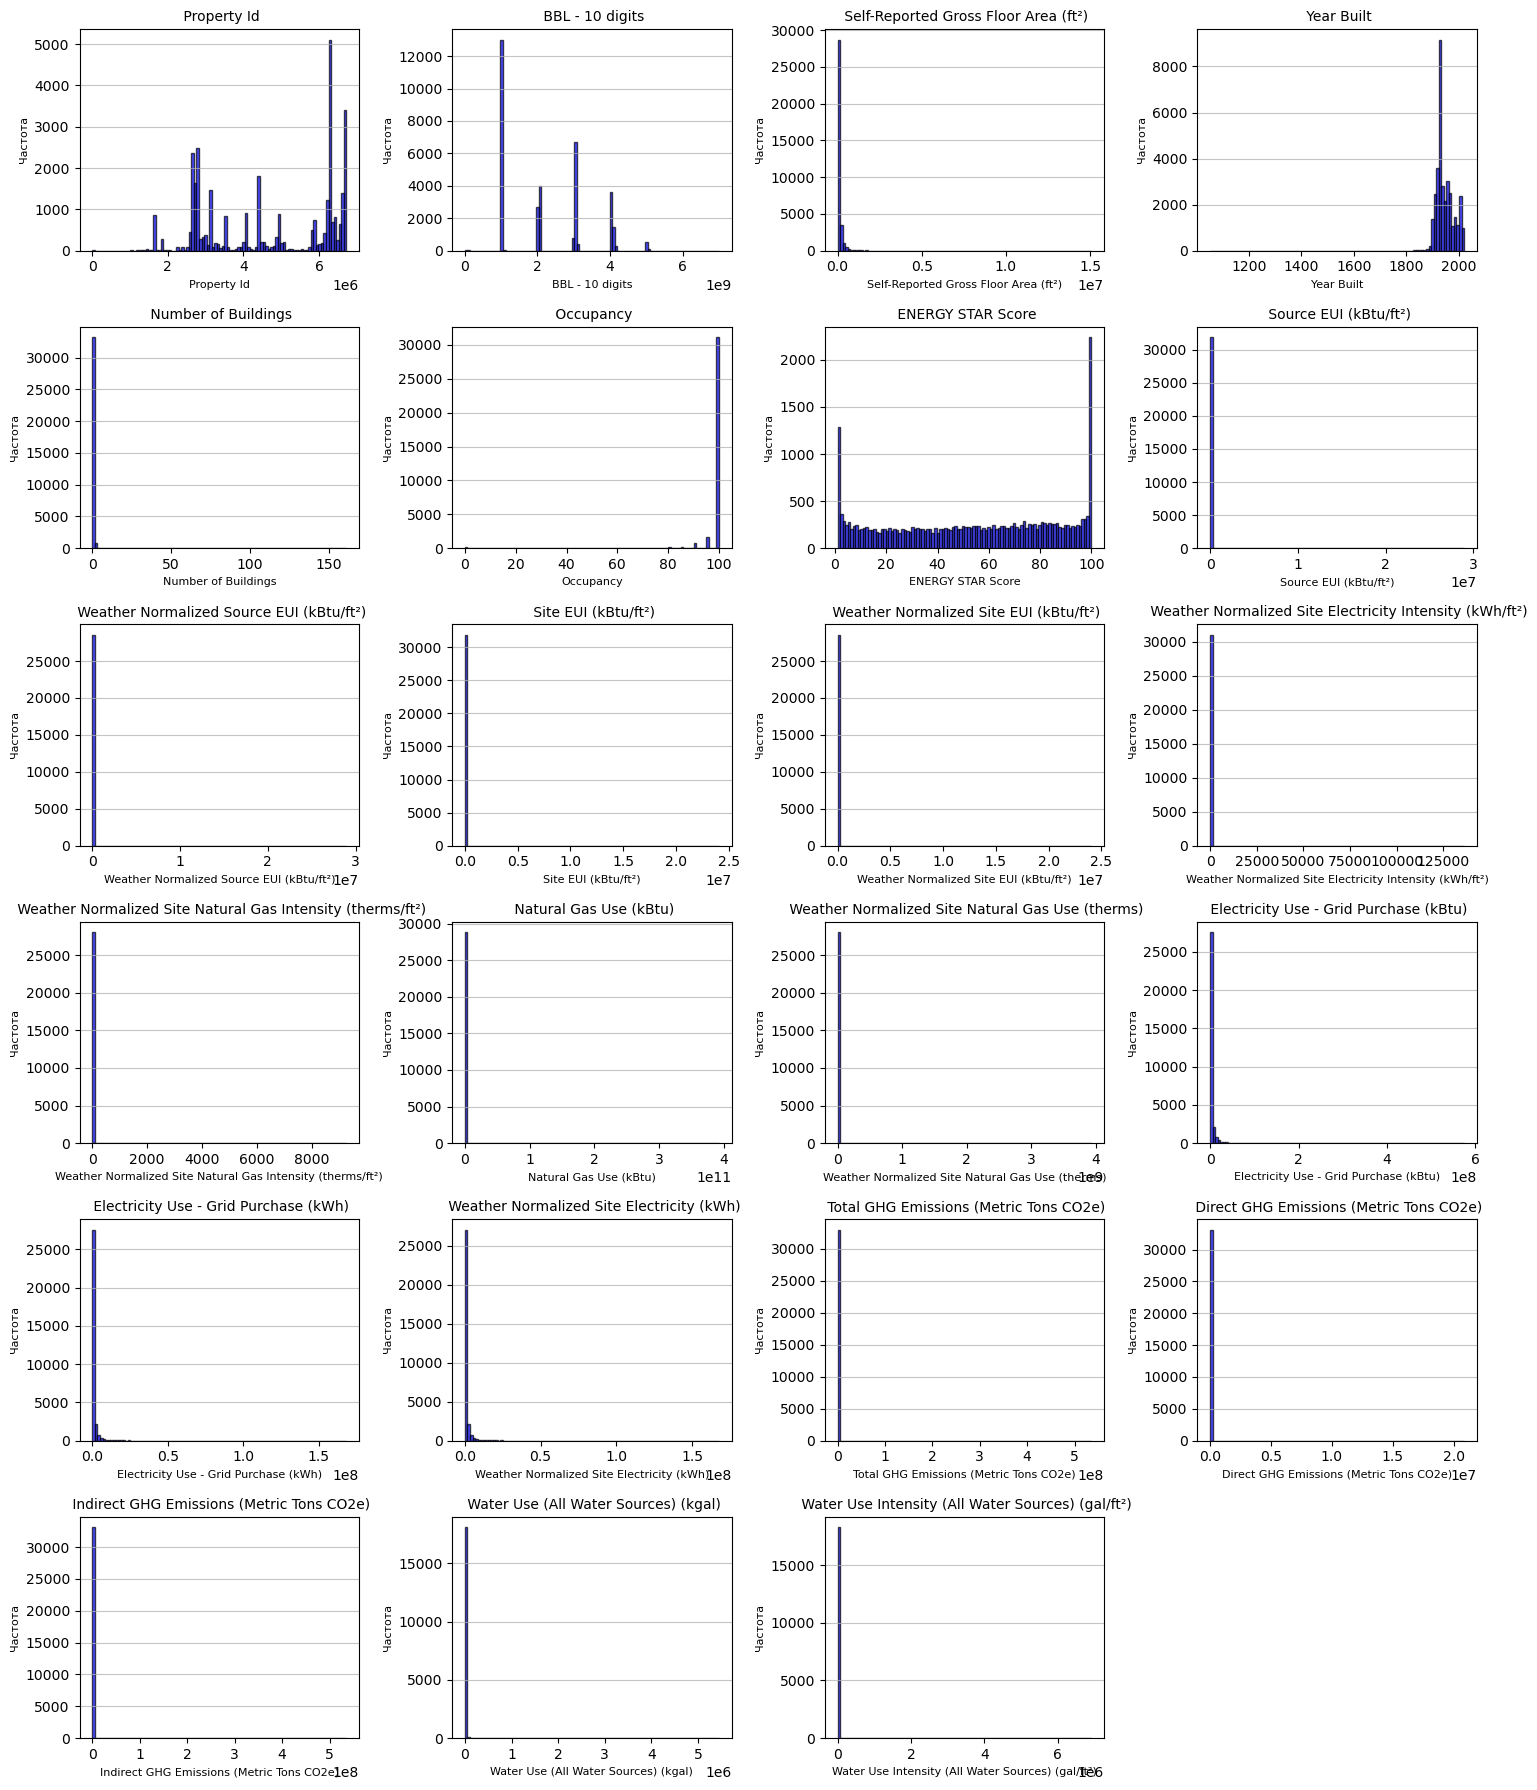

In [71]:
num_cols = len(cols)
n_cols = 4  # Количество графиков в строке
n_rows = (num_cols + n_cols - 1) // n_cols  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))  # Увеличенный размер фигуры

# Превращаем axes в одномерный массив для удобства
axes = axes.flatten()

# Построение гистограмм для каждого признака
for i, col in enumerate(cols):
    axes[i].hist(df_new_dr[col], bins=100, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f' {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Частота', fontsize=8)
    axes[i].grid(axis='y', alpha=0.75)

# Убираем пустые подграфики, если они есть
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Настройка отступов
plt.tight_layout()
plt.show()

Из гистограмм распределения видно, что многие признаки сконцентрированы вокруг одного значения (скорее всего, мало уникальных значений, т.е. признаки имеют высокую степень однородности или дискретности). Это может указывать на то, что данные содержат много повторяющихся значений, что может быть характерно для категориальных переменных или для непрерывных переменных с небольшим диапазоном.

Такое распределение может также говорить о наличии выбросов или аномалий в данных. 

Боксплоты

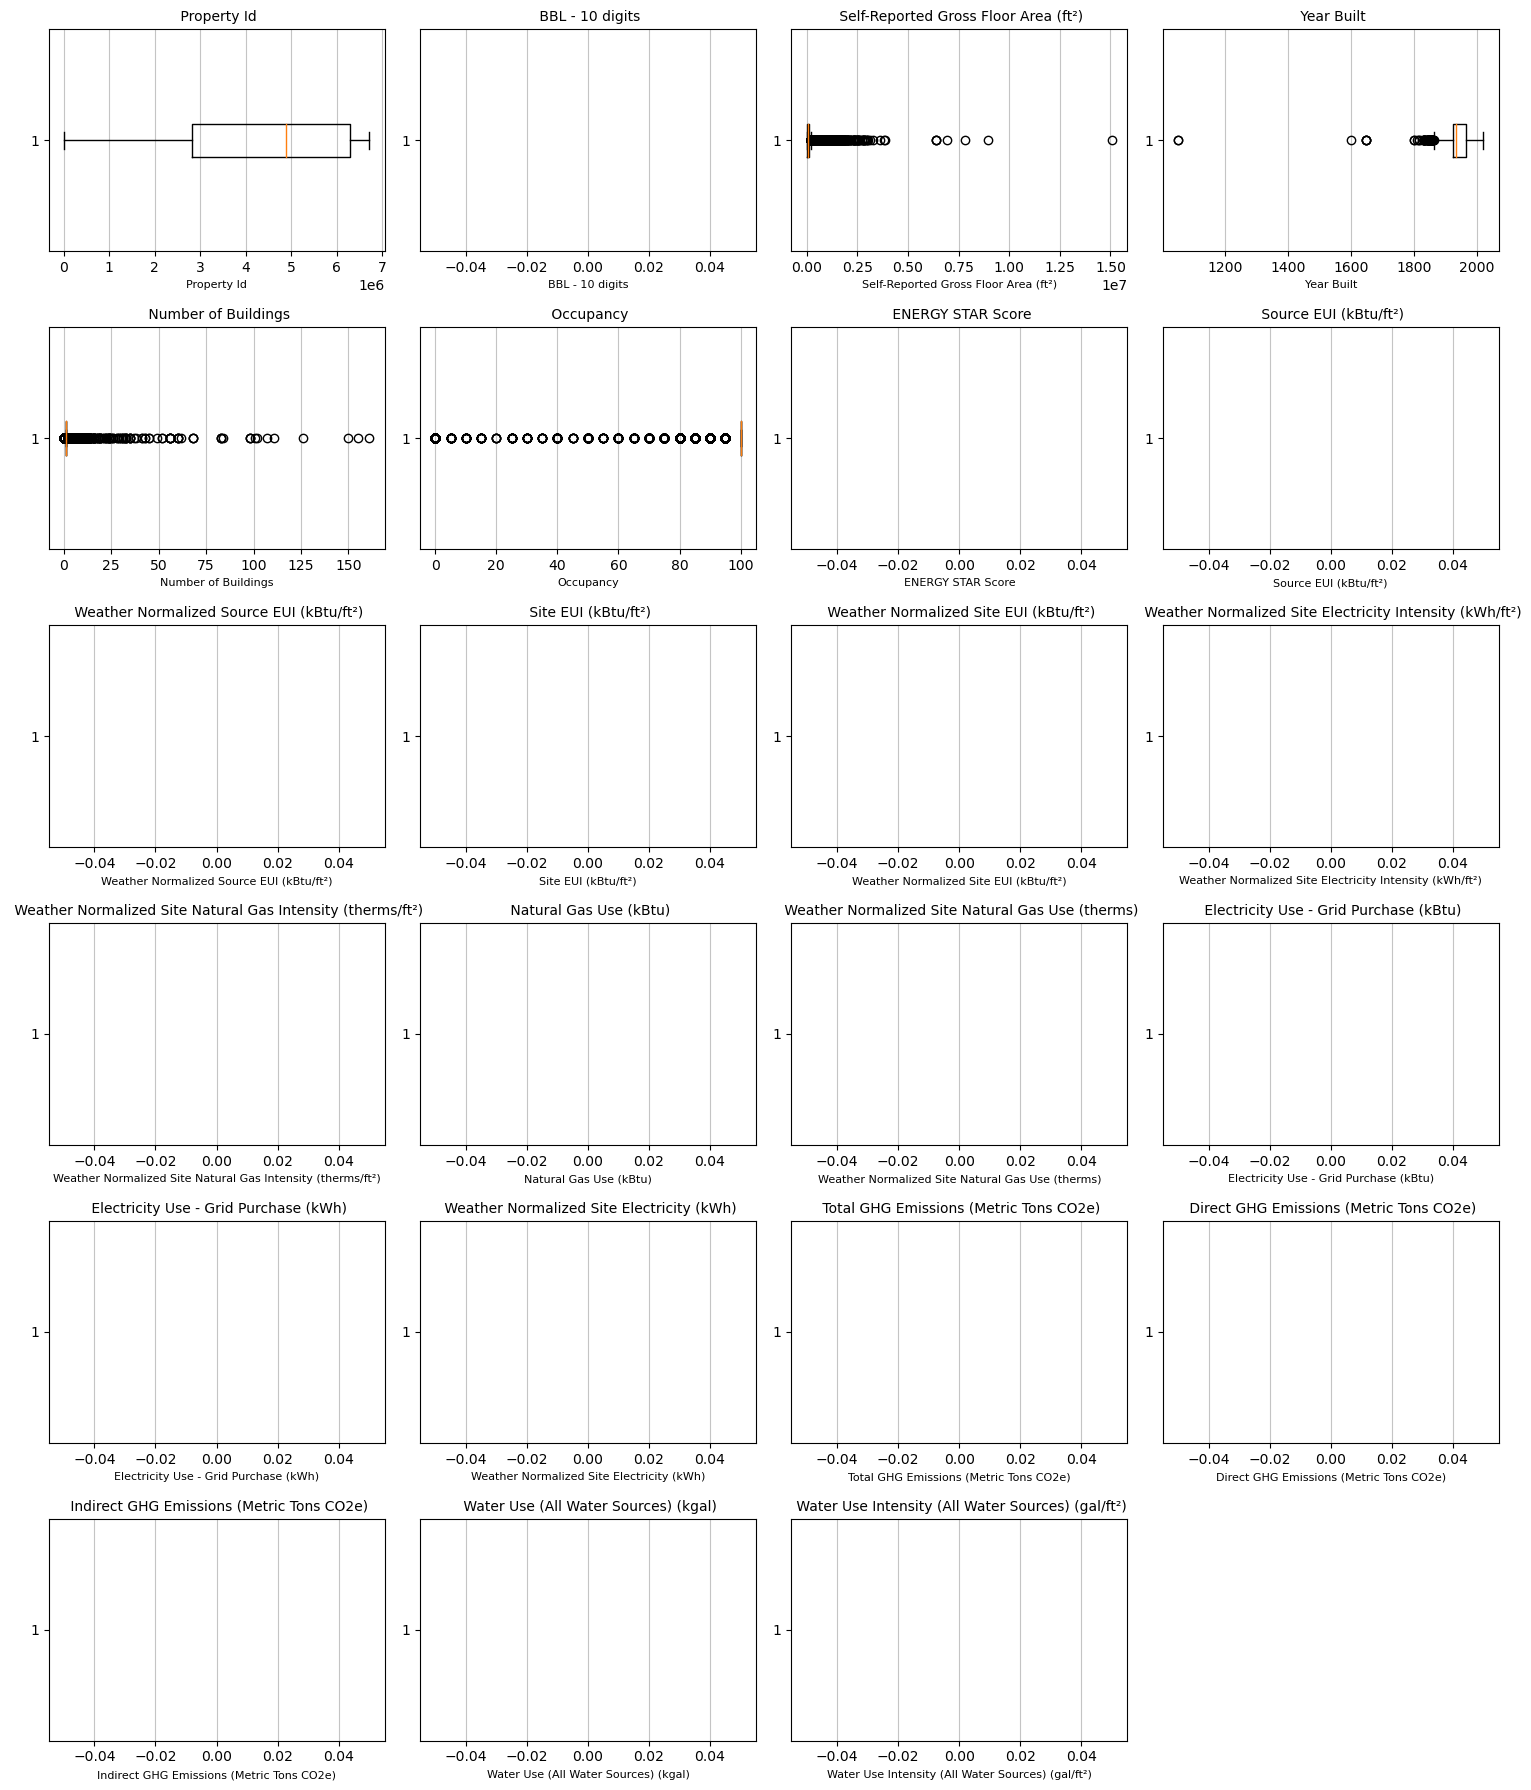

In [72]:
num_cols = len(cols)
n_cols = 4  # Количество графиков в строке
n_rows = (num_cols + n_cols - 1) // n_cols  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))  # Увеличенный размер фигуры

# Превращаем axes в одномерный массив для удобства
axes = axes.flatten()

# Построение боксплотов для каждого признака
for i, col in enumerate(cols):
    axes[i].boxplot(df_new_dr[col], vert=False)  # Горизонтальный боксплот
    axes[i].set_title(f' {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].grid(axis='x', alpha=0.75)

# Убираем пустые подграфики, если они есть
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Настройка отступов
plt.tight_layout()
plt.show()

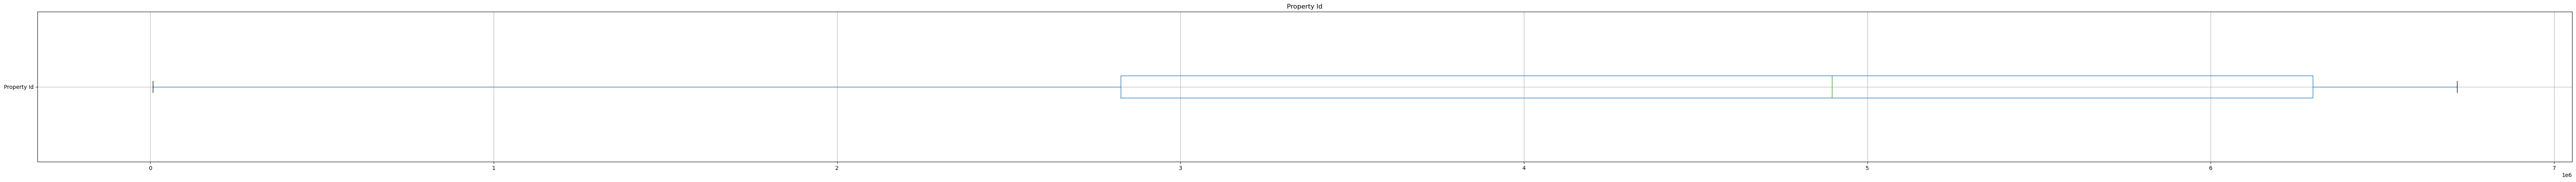

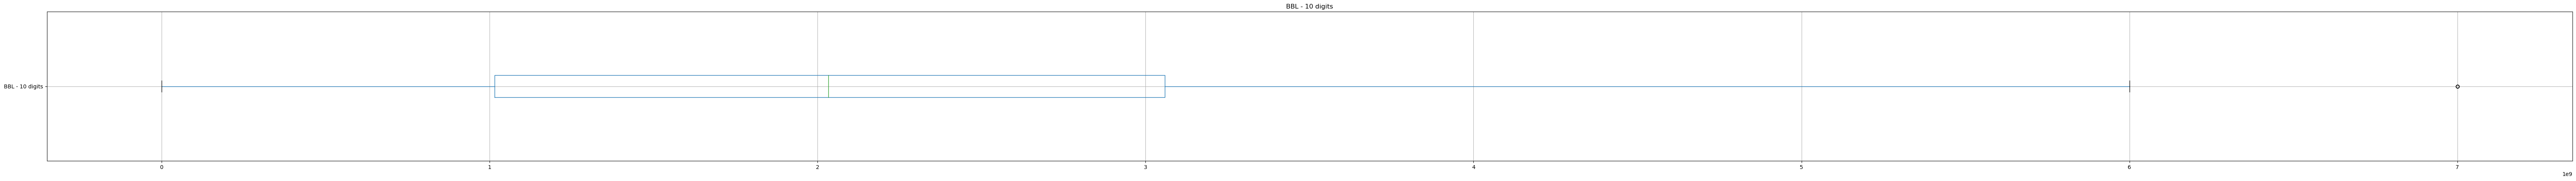

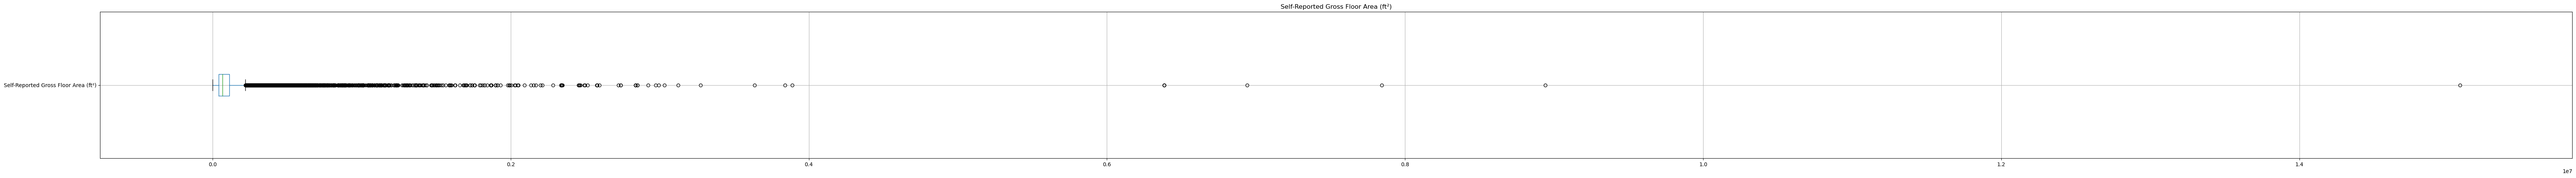

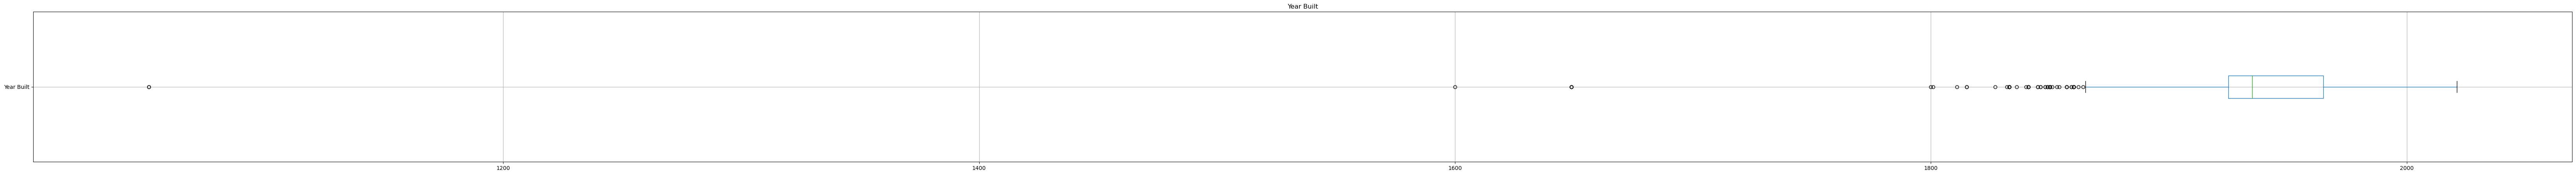

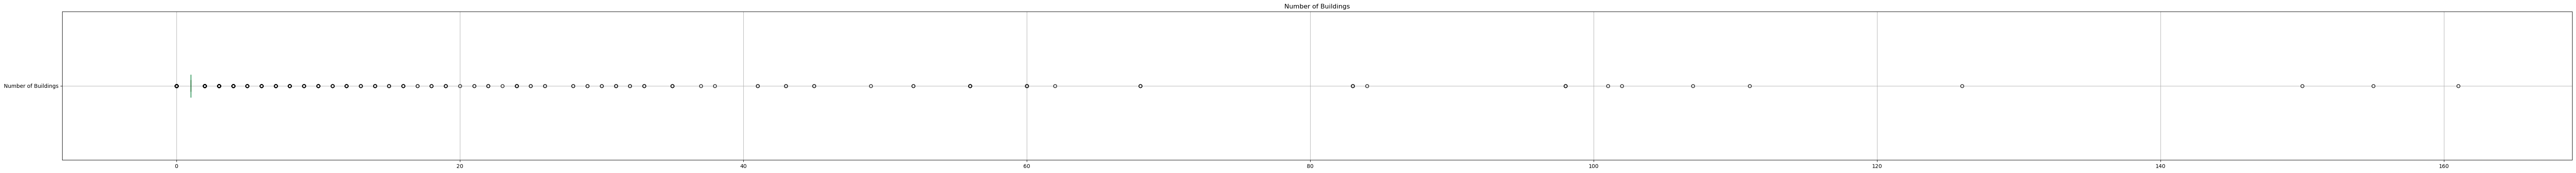

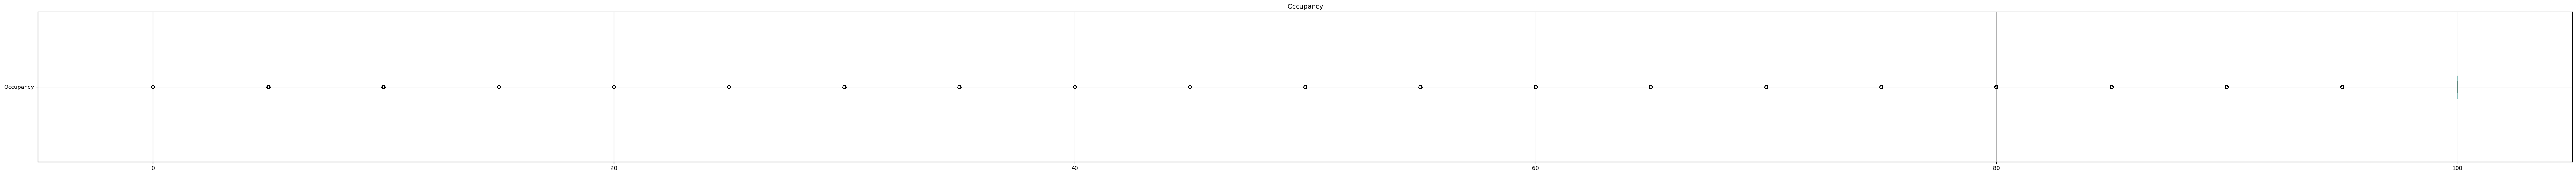

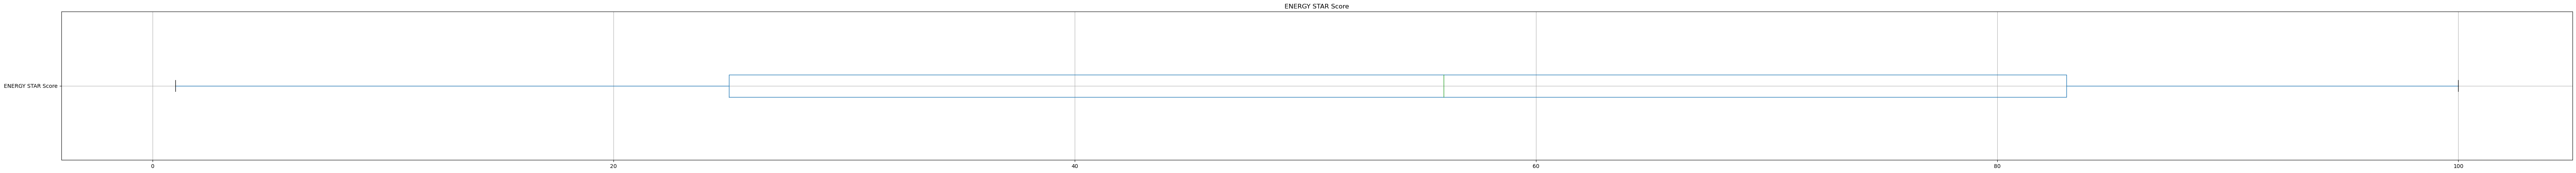

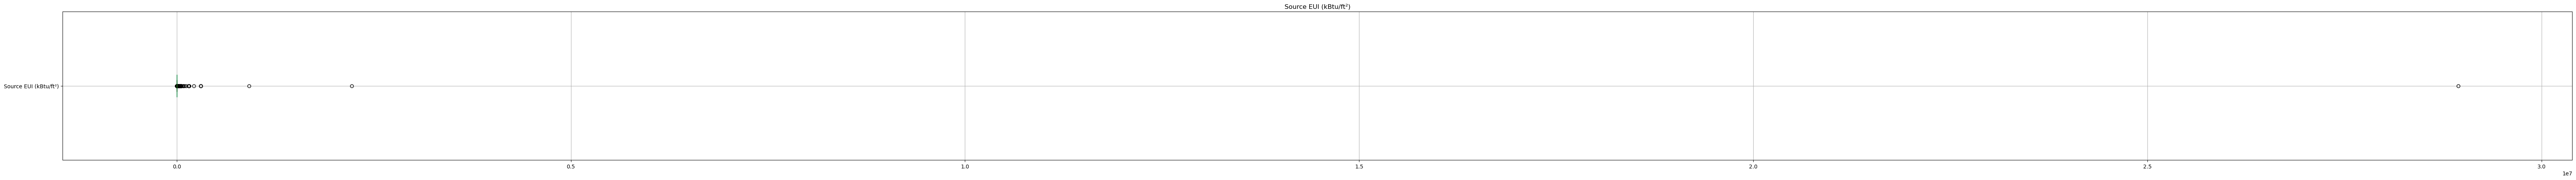

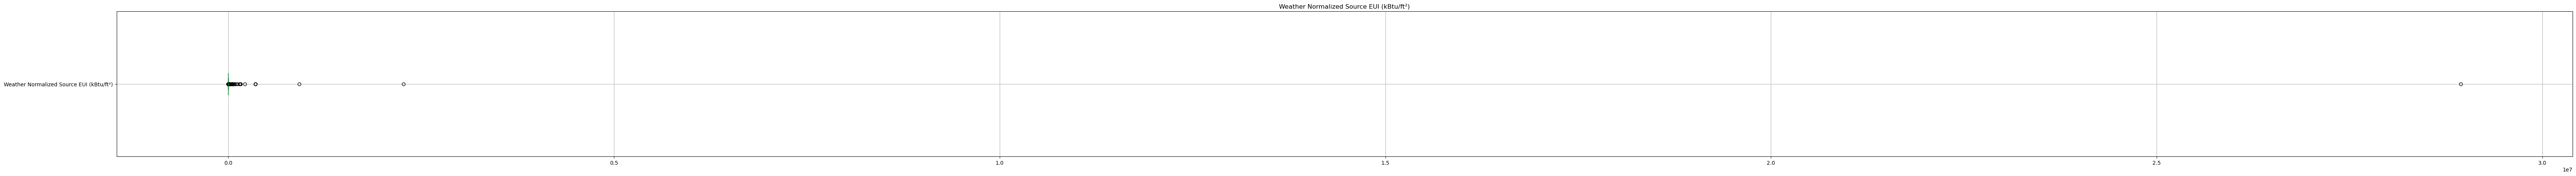

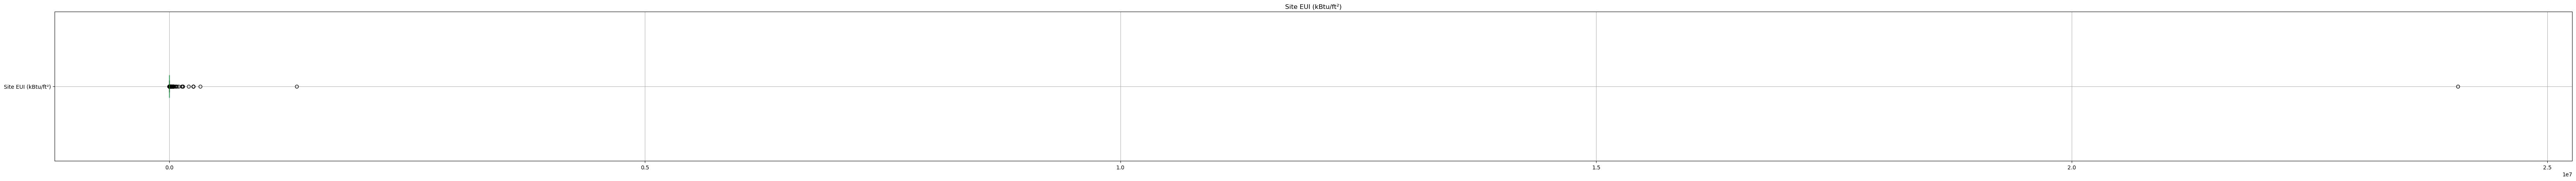

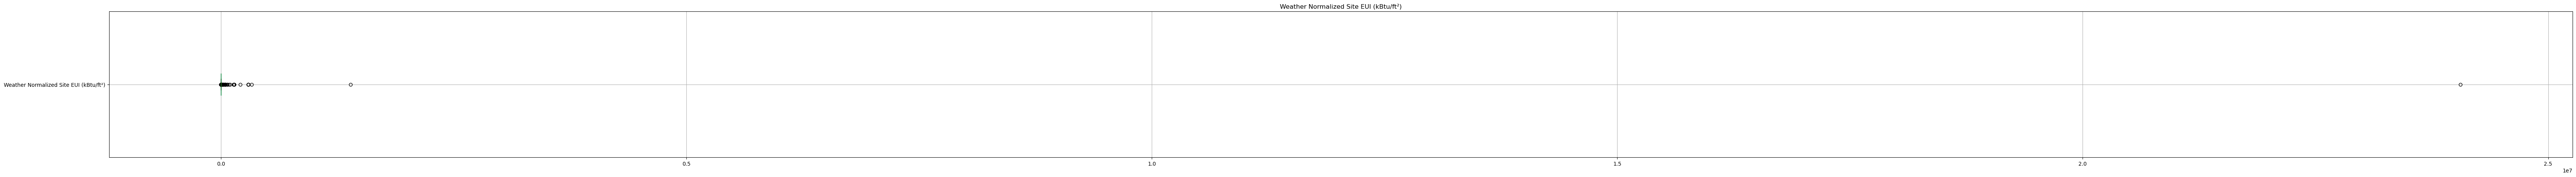

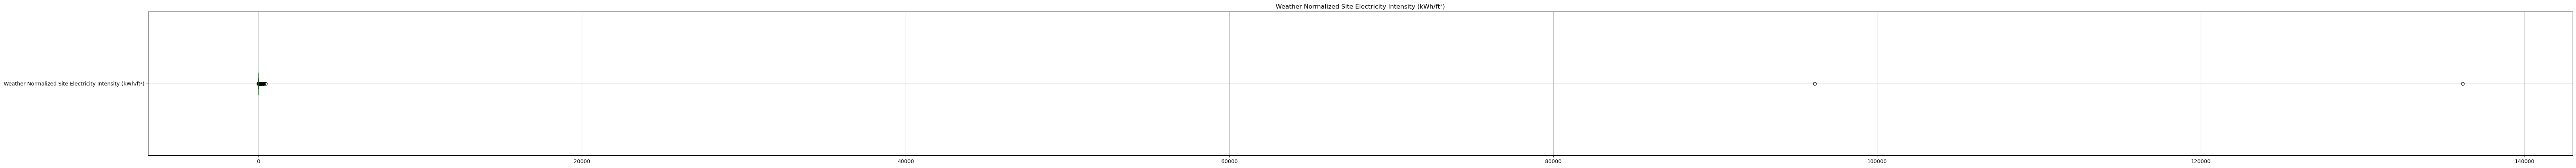

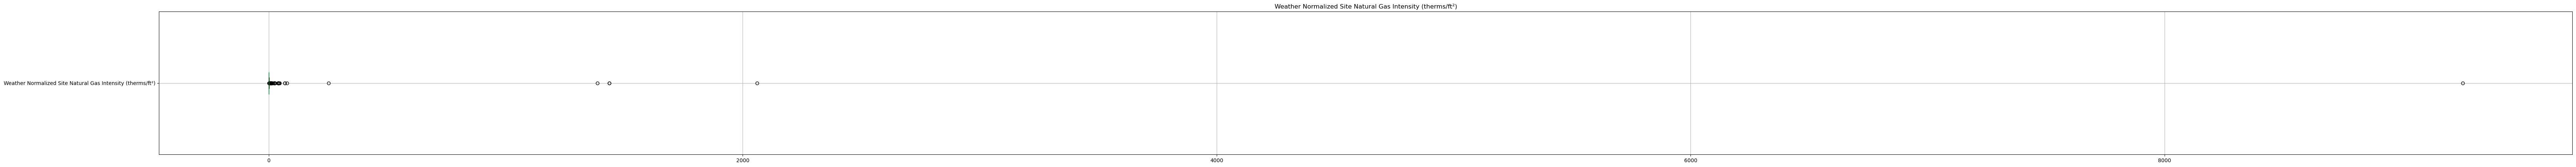

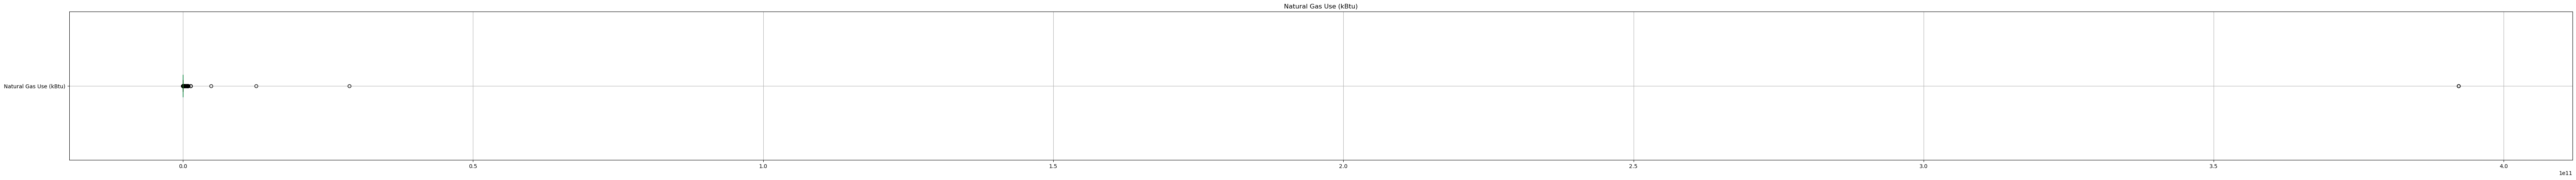

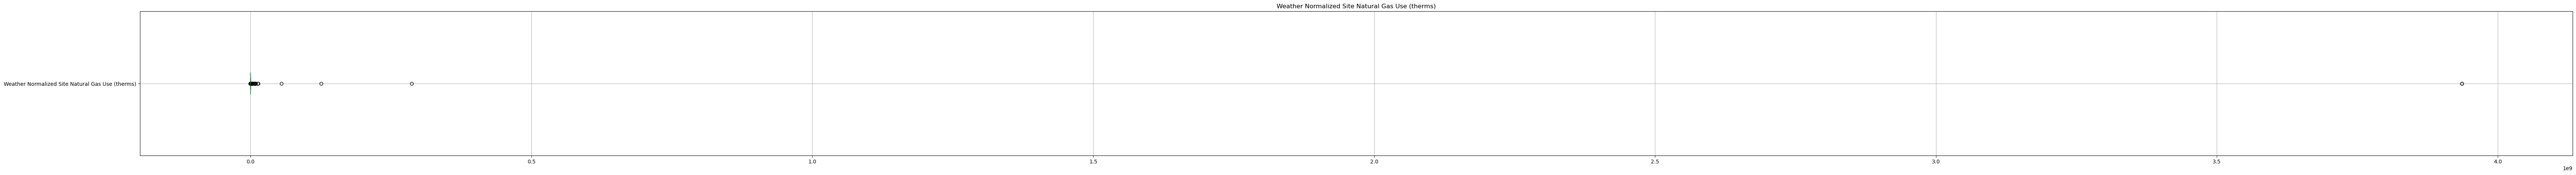

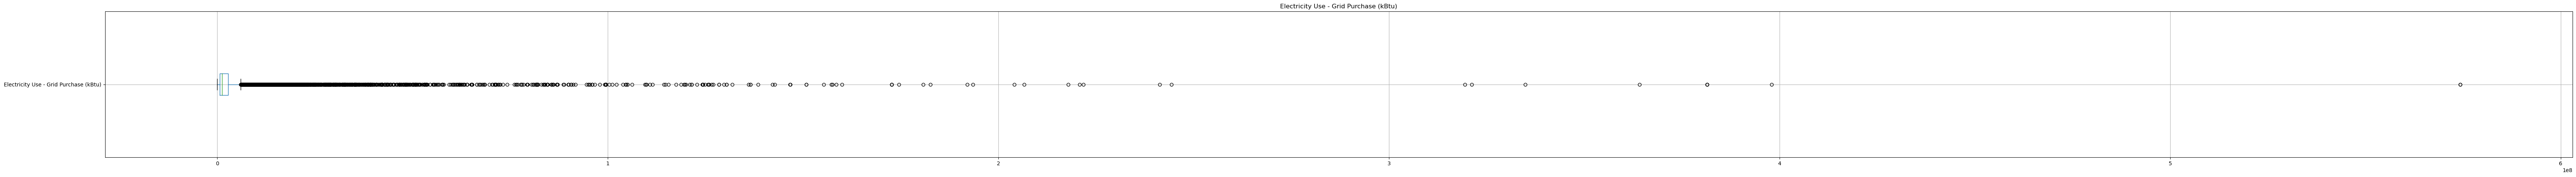

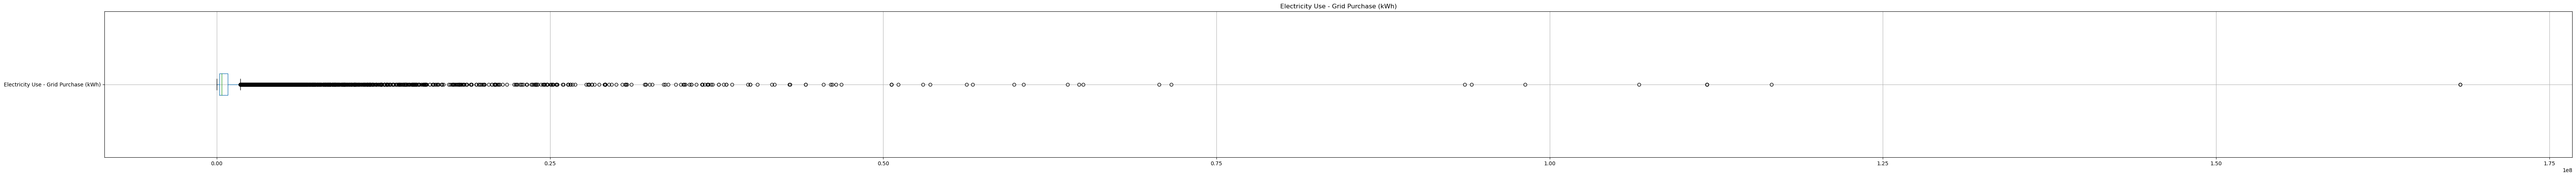

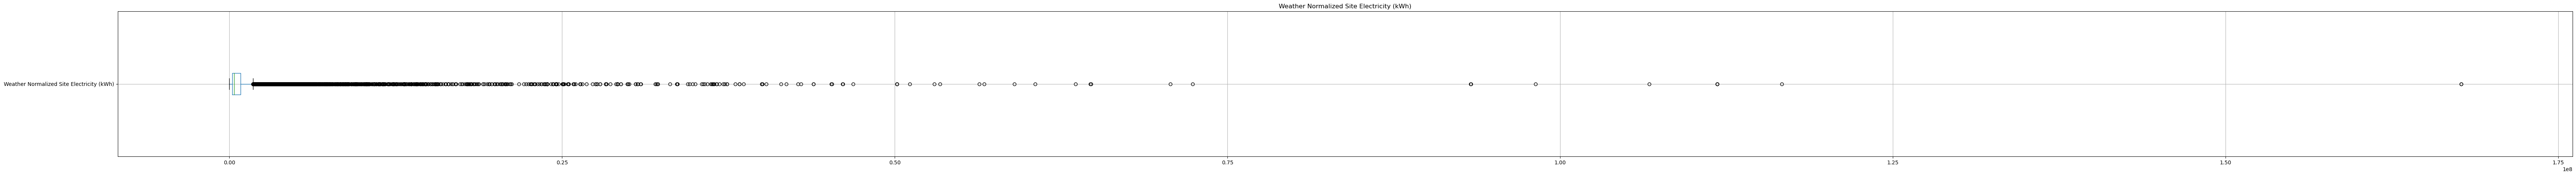

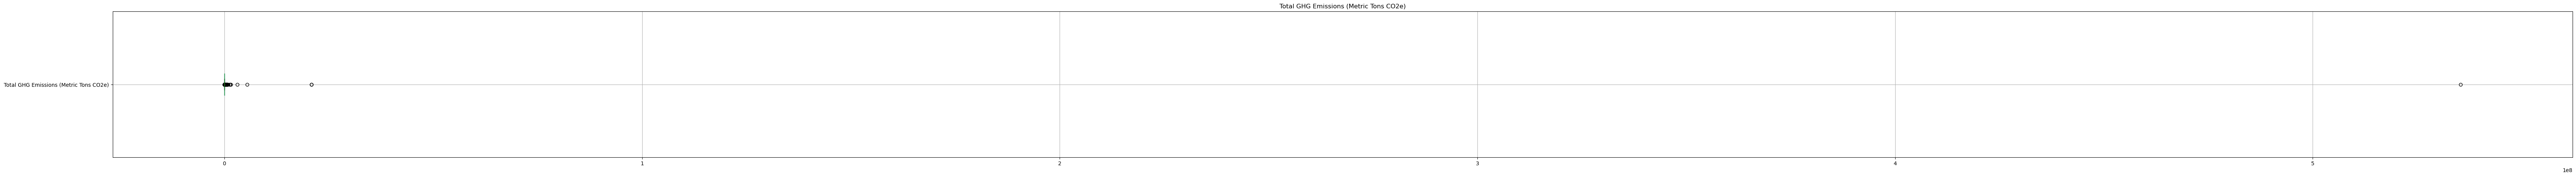

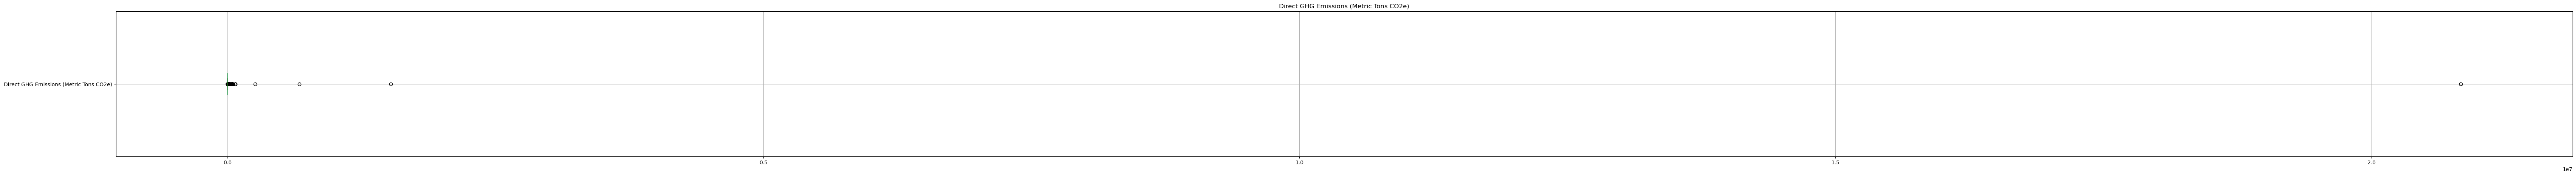

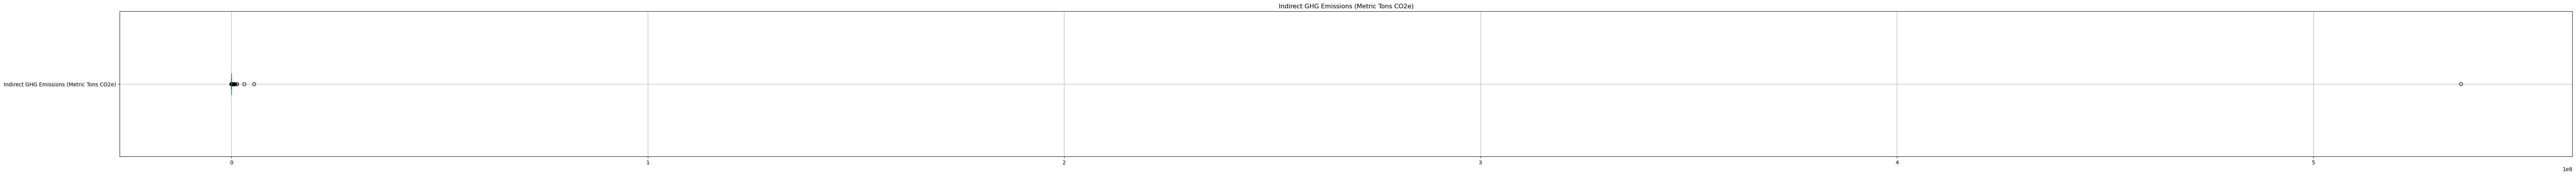

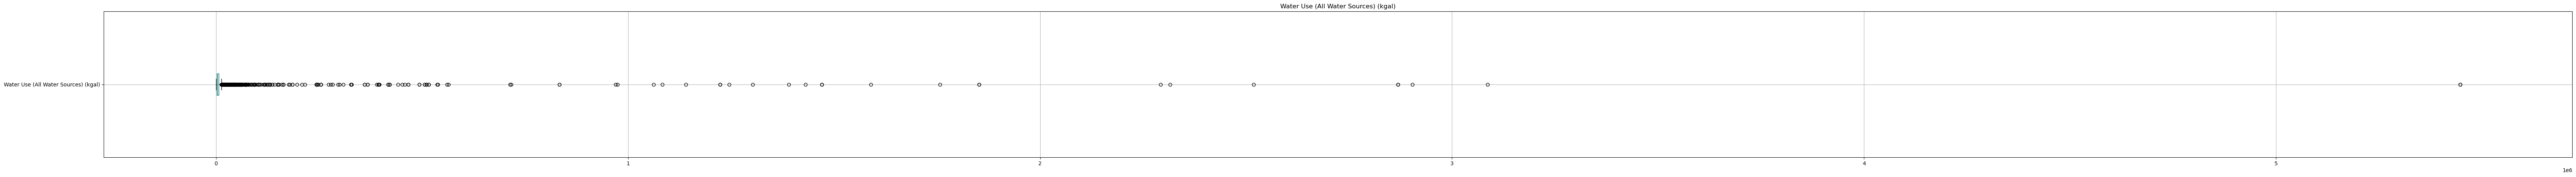

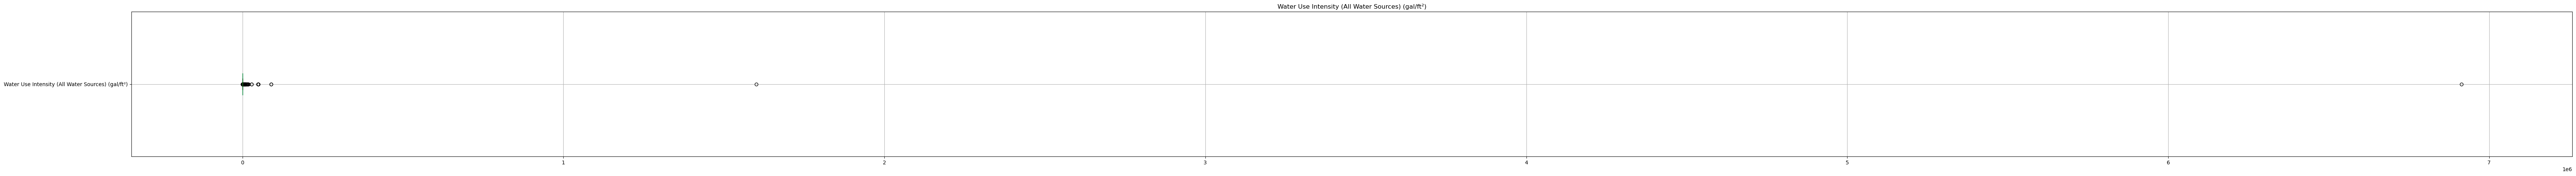

In [73]:
for ind, col in enumerate(cols):
    ymin = df_new_dr[col].min()
    ymax = df_new_dr[col].max()
    boxplot = df_new_dr.boxplot([col], vert=False, figsize=(100,5))

    # Добавляем заголовок с именем столбца
    plt.title(col)

    #diff = (ymax-ymin)/34355
    #boxplot.set_xlim([ymin-diff, ymax+diff])
    plt.subplots_adjust(left=0.25)
    plt.show()

Из боксплотов видно, что в данных присутствуют столбцы с одной уникальной величиной либо с очень низким разнообразием значений. Также присутствуют выбросы и много пропущенных значений.

In [74]:
df_new_dr.nunique()

Property Id                                                   22485
BBL - 10 digits                                               20887
Self-Reported Gross Floor Area (ft²)                          16666
Year Built                                                      179
Number of Buildings                                              56
Occupancy                                                        21
ENERGY STAR Score                                               100
Source EUI (kBtu/ft²)                                          3982
Weather Normalized Source EUI (kBtu/ft²)                       3917
Site EUI (kBtu/ft²)                                            2604
Weather Normalized Site EUI (kBtu/ft²)                         2602
Weather Normalized Site Electricity Intensity (kWh/ft²)         600
Weather Normalized Site Natural Gas Intensity (therms/ft²)       95
Natural Gas Use (kBtu)                                        19736
Weather Normalized Site Natural Gas Use (therms)

# Чистка датасета

### Обработка пропущенных значений:

In [75]:
df_new_dr.isnull().sum()

Property Id                                                       0
BBL - 10 digits                                                 730
Self-Reported Gross Floor Area (ft²)                              0
Year Built                                                        0
Number of Buildings                                               0
Occupancy                                                         0
ENERGY STAR Score                                              8901
Source EUI (kBtu/ft²)                                          2467
Weather Normalized Source EUI (kBtu/ft²)                       5795
Site EUI (kBtu/ft²)                                            2467
Weather Normalized Site EUI (kBtu/ft²)                         5795
Weather Normalized Site Electricity Intensity (kWh/ft²)        3354
Weather Normalized Site Natural Gas Intensity (therms/ft²)     6313
Natural Gas Use (kBtu)                                         5536
Weather Normalized Site Natural Gas Use (therms)

В первую очередь избавимся от пропусков. 
Пропуски в столбце BBL - 10 digits (идентификатор недвижимости) сразу удаляются, так как заполнить их никак нельзя.

In [76]:
df_cleaned = df_new_dr.dropna(subset=['BBL - 10 digits'])

Также удалим столбцы Water Use (All Water Sources) (kgal)  и Water Use Intensity (All Water Sources) (gal/ft²), поскольку в них пропусков также очень много.

In [77]:
df_cleaned = df_cleaned.drop(columns = ['Water Use (All Water Sources) (kgal)', 'Water Use Intensity (All Water Sources) (gal/ft²)'])

In [78]:
df_cleaned.isnull().sum()

Property Id                                                      0
BBL - 10 digits                                                  0
Self-Reported Gross Floor Area (ft²)                             0
Year Built                                                       0
Number of Buildings                                              0
Occupancy                                                        0
ENERGY STAR Score                                             8600
Source EUI (kBtu/ft²)                                         2357
Weather Normalized Source EUI (kBtu/ft²)                      5570
Site EUI (kBtu/ft²)                                           2357
Weather Normalized Site EUI (kBtu/ft²)                        5570
Weather Normalized Site Electricity Intensity (kWh/ft²)       3199
Weather Normalized Site Natural Gas Intensity (therms/ft²)    6011
Natural Gas Use (kBtu)                                        5295
Weather Normalized Site Natural Gas Use (therms)              

Остальные пропуски попробуем заменить методом k ближайших соседей (kNN)

In [79]:
# Инициализация KNNImputer с указанием количества соседей (n_neighbors)
imputer = KNNImputer(n_neighbors=5)

# Применение fit_transform к DataFrame
imp = imputer.fit_transform(df_cleaned)

In [80]:
df_imputed = pd.DataFrame(imp, columns=df_cleaned.columns)

In [82]:
df_imputed[cols[-6:]].describe() # у 4 признаков есть отрицательные значения, такие строки подлежат удалению

In [83]:
df_imputed = df_imputed[(df_imputed >= 0).all(axis=1)]

In [84]:
df_imputed.isnull().sum()

Property Id                                                   0
BBL - 10 digits                                               0
Self-Reported Gross Floor Area (ft²)                          0
Year Built                                                    0
Number of Buildings                                           0
Occupancy                                                     0
ENERGY STAR Score                                             0
Source EUI (kBtu/ft²)                                         0
Weather Normalized Source EUI (kBtu/ft²)                      0
Site EUI (kBtu/ft²)                                           0
Weather Normalized Site EUI (kBtu/ft²)                        0
Weather Normalized Site Electricity Intensity (kWh/ft²)       0
Weather Normalized Site Natural Gas Intensity (therms/ft²)    0
Natural Gas Use (kBtu)                                        0
Weather Normalized Site Natural Gas Use (therms)              0
Electricity Use - Grid Purchase (kBtu)  

Проверим, как стали выглядить распределения признаков

In [85]:
df_imputed.columns

Index(['Property Id', 'BBL - 10 digits',
       'Self-Reported Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings', 'Occupancy', 'ENERGY STAR Score',
       'Source EUI (kBtu/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Natural Gas Use (kBtu)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Electricity Use - Grid Purchase (kWh)',
       'Weather Normalized Site Electricity (kWh)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)'],
      dtype='object')

Признак Property_id не является информативным, его мы также удалим

In [86]:
df_imputed = df_imputed.drop(['Property Id'], axis = 1)

In [87]:
cols = ['BBL - 10 digits',
       'Self-Reported Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings', 'Occupancy', 'ENERGY STAR Score',
       'Source EUI (kBtu/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Natural Gas Use (kBtu)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Electricity Use - Grid Purchase (kWh)',
       'Weather Normalized Site Electricity (kWh)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)']

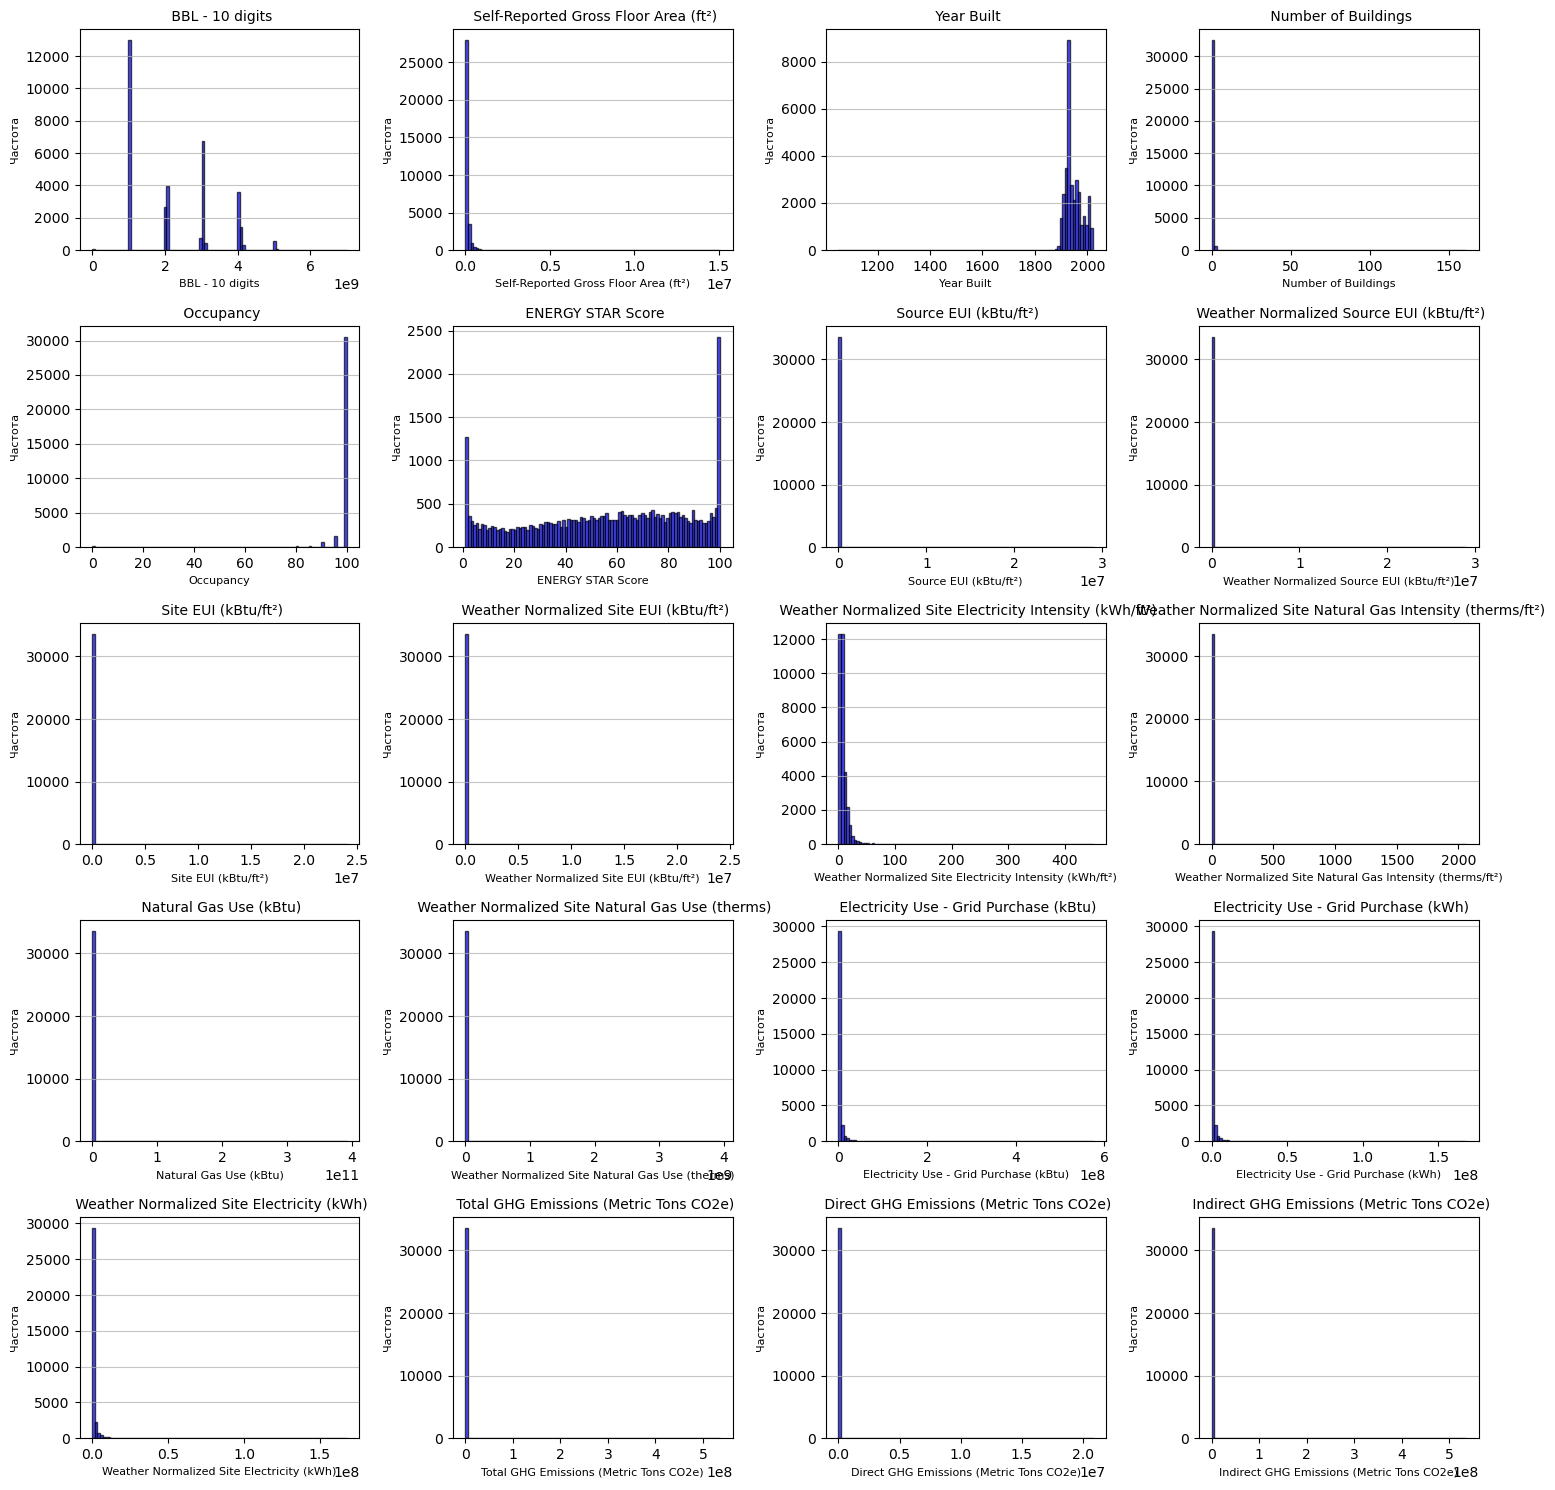

In [88]:
num_cols = len(cols)
n_cols = 4  # Количество графиков в строке
n_rows = (num_cols + n_cols - 1) // n_cols  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))  # Увеличенный размер фигуры

# Превращаем axes в одномерный массив для удобства
axes = axes.flatten()

# Построение гистограмм для каждого признака
for i, col in enumerate(cols):
    axes[i].hist(df_imputed[col], bins=100, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f' {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Частота', fontsize=8)
    axes[i].grid(axis='y', alpha=0.75)

# Убираем пустые подграфики, если они есть
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Настройка отступов
plt.tight_layout()
plt.show()

Особо не изменились. Теперь посмотрим на боксплоты

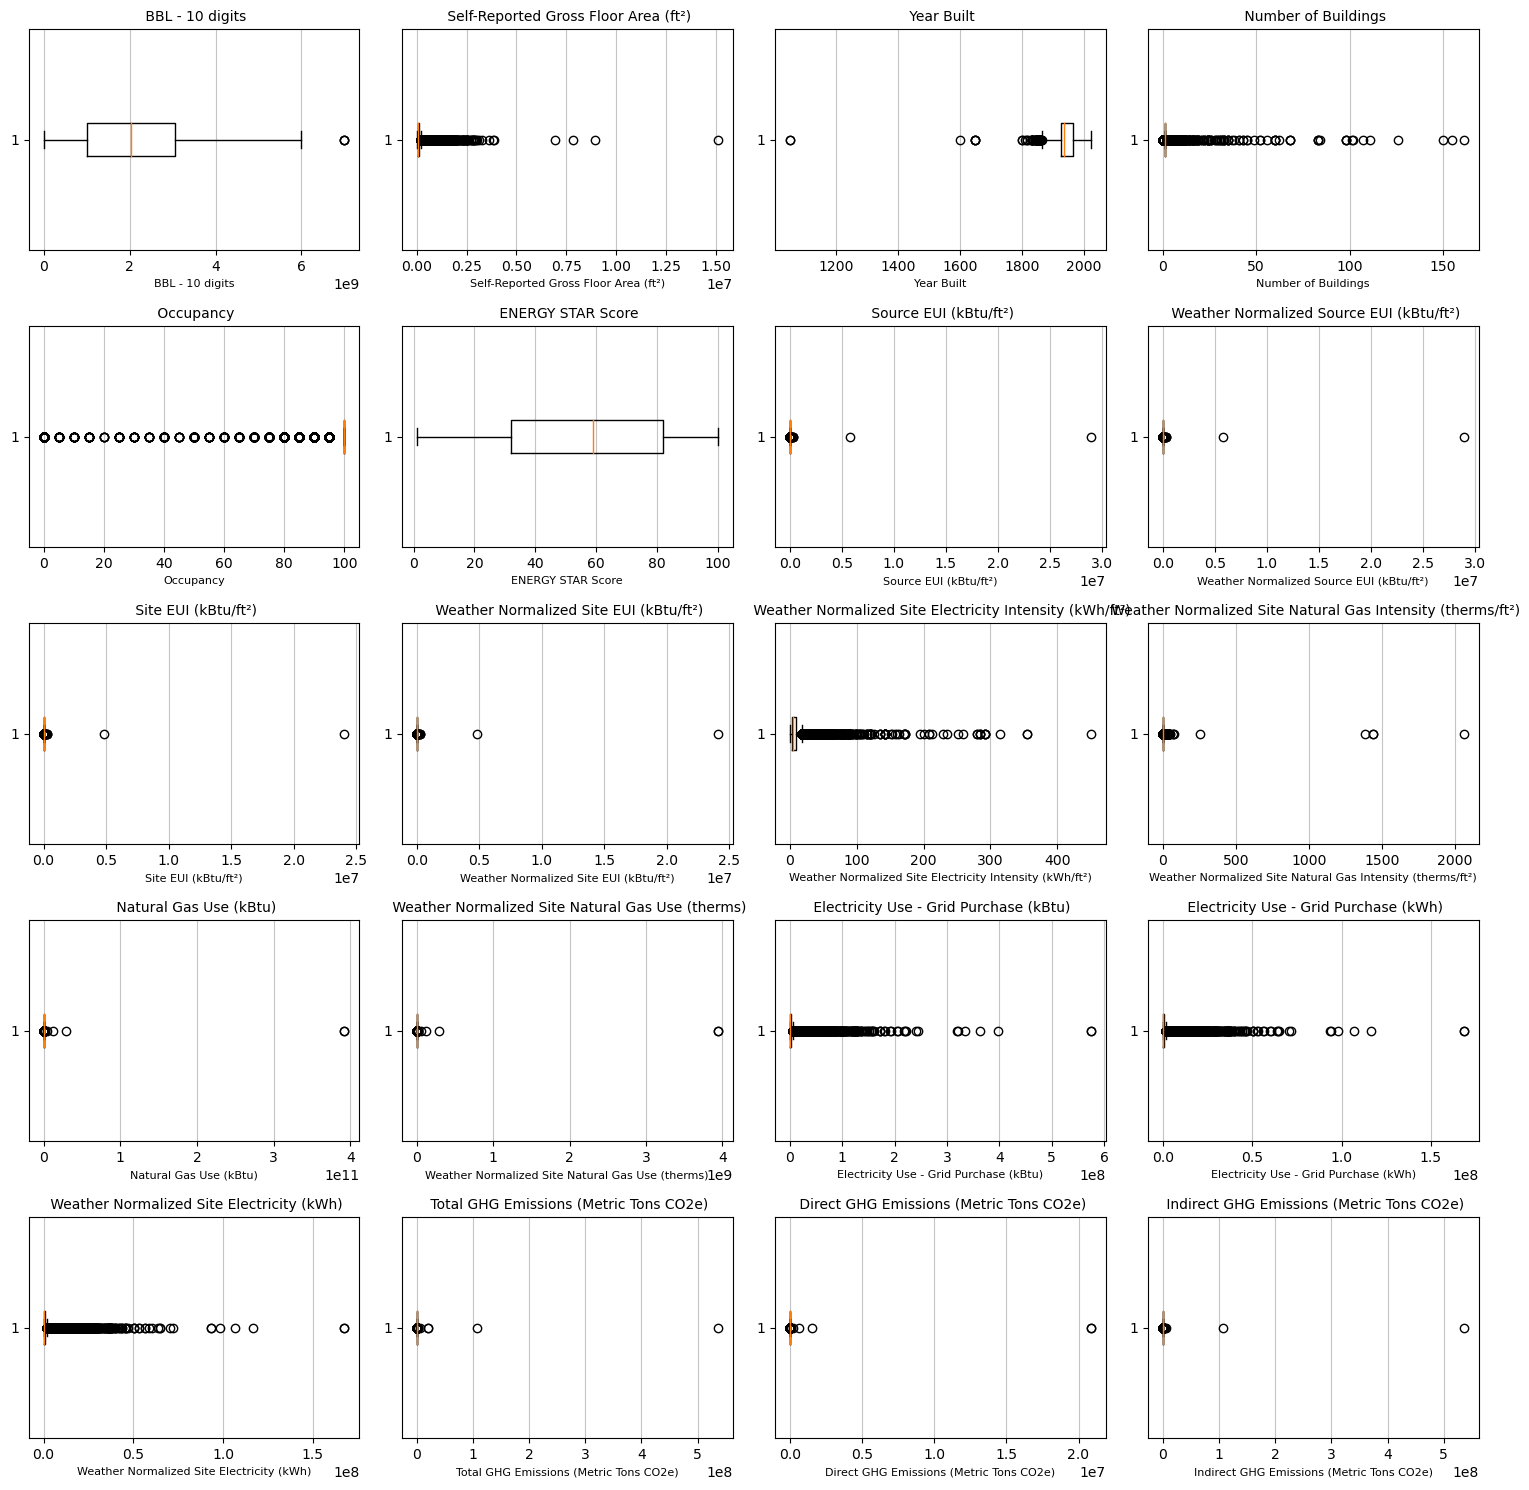

In [89]:
num_cols = len(cols)
n_cols = 4  # Количество графиков в строке
n_rows = (num_cols + n_cols - 1) // n_cols  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))  # Увеличенный размер фигуры

# Превращаем axes в одномерный массив для удобства
axes = axes.flatten()

# Построение боксплотов для каждого признака
for i, col in enumerate(cols):
    axes[i].boxplot(df_imputed[col], vert=False)  # Горизонтальный боксплот
    axes[i].set_title(f' {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].grid(axis='x', alpha=0.75)

# Убираем пустые подграфики, если они есть
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Настройка отступов
plt.tight_layout()
plt.show()

Теперь хотя бы видно выбросы.

## Обнаружение и устранение отклонений: 

### Боксококсим!

In [99]:
len(cols)

20

In [104]:
df_box = pd.DataFrame()
for i in cols:
    df_box[f'{i}_box'], lmbda = boxcox(df_imputed[i].values+0.0000001)
range_scale_box = [i+'_box' for i in cols]

In [94]:
df_box

,BBL - 10 digits_box,Self-Reported Gross Floor Area (ft²)_box,Year Built_box,Number of Buildings_box,Occupancy_box,ENERGY STAR Score_box,Source EUI (kBtu/ft²)_box,Weather Normalized Source EUI (kBtu/ft²)_box,Site EUI (kBtu/ft²)_box,Weather Normalized Site EUI (kBtu/ft²)_box,Weather Normalized Site Electricity Intensity (kWh/ft²)_box,Weather Normalized Site Natural Gas Intensity (therms/ft²)_box,Natural Gas Use (kBtu)_box,Weather Normalized Site Natural Gas Use (therms)_box,Electricity Use - Grid Purchase (kBtu)_box,Electricity Use - Grid Purchase (kWh)_box,Weather Normalized Site Electricity (kWh)_box,Total GHG Emissions (Metric Tons CO2e)_box,Direct GHG Emissions (Metric Tons CO2e)_box,Indirect GHG Emissions (Metric Tons CO2e)_box
0,2460.288,13.555,231296986.321,0.000,199213754710.121,50.191,7.553,7.717,5.543,5.701,3.371,-1.740,63.490,26.338,60.609,49.451,51.799,12.182,6.907,11.390
1,3839.409,12.821,249250190.024,0.000,272549418103.235,54.920,5.204,5.405,4.405,4.623,0.759,-1.319,68.091,28.299,40.965,33.075,34.454,8.129,7.810,5.602
2,2458.719,13.172,261689765.366,0.000,100957945621.116,46.829,9.134,9.337,7.319,7.500,4.388,-0.341,88.477,37.337,62.642,51.146,53.617,13.624,11.899,11.624
3,2458.711,12.033,259939303.658,0.000,272549418103.235,17.595,7.922,8.124,6.221,6.424,3.436,-0.817,66.643,27.550,49.808,40.449,42.214,9.394,7.524,8.033
4,2452.697,12.033,266275492.116,0.000,-0.164,54.450,5.945,6.024,3.867,3.905,2.278,-0.669,69.543,28.795,44.626,36.128,37.576,6.779,-4.790,6.604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33618,3513.579,11.516,238509769.533,0.000,272549418103.235,28.665,7.303,7.576,6.795,7.077,1.179,0.000,73.172,30.495,36.542,29.387,30.432,8.439,8.815,4.327
33619,3499.023,11.499,236528869.620,0.000,272549418103.235,35.933,7.246,7.519,6.771,7.049,1.034,0.000,72.950,30.385,35.723,28.704,29.710,8.361,8.771,4.107
33620,3526.596,11.552,236858300.604,0.000,272549418103.235,11.571,7.817,8.044,7.094,7.326,2.142,0.000,74.571,30.969,41.114,33.200,34.468,8.955,9.093,5.556
33621,2462.516,14.113,231621831.671,0.000,272549418103.235,50.191,6.279,7.794,4.387,6.648,2.688,-3.847,49.390,19.061,61.233,49.971,52.288,11.652,4.421,11.099


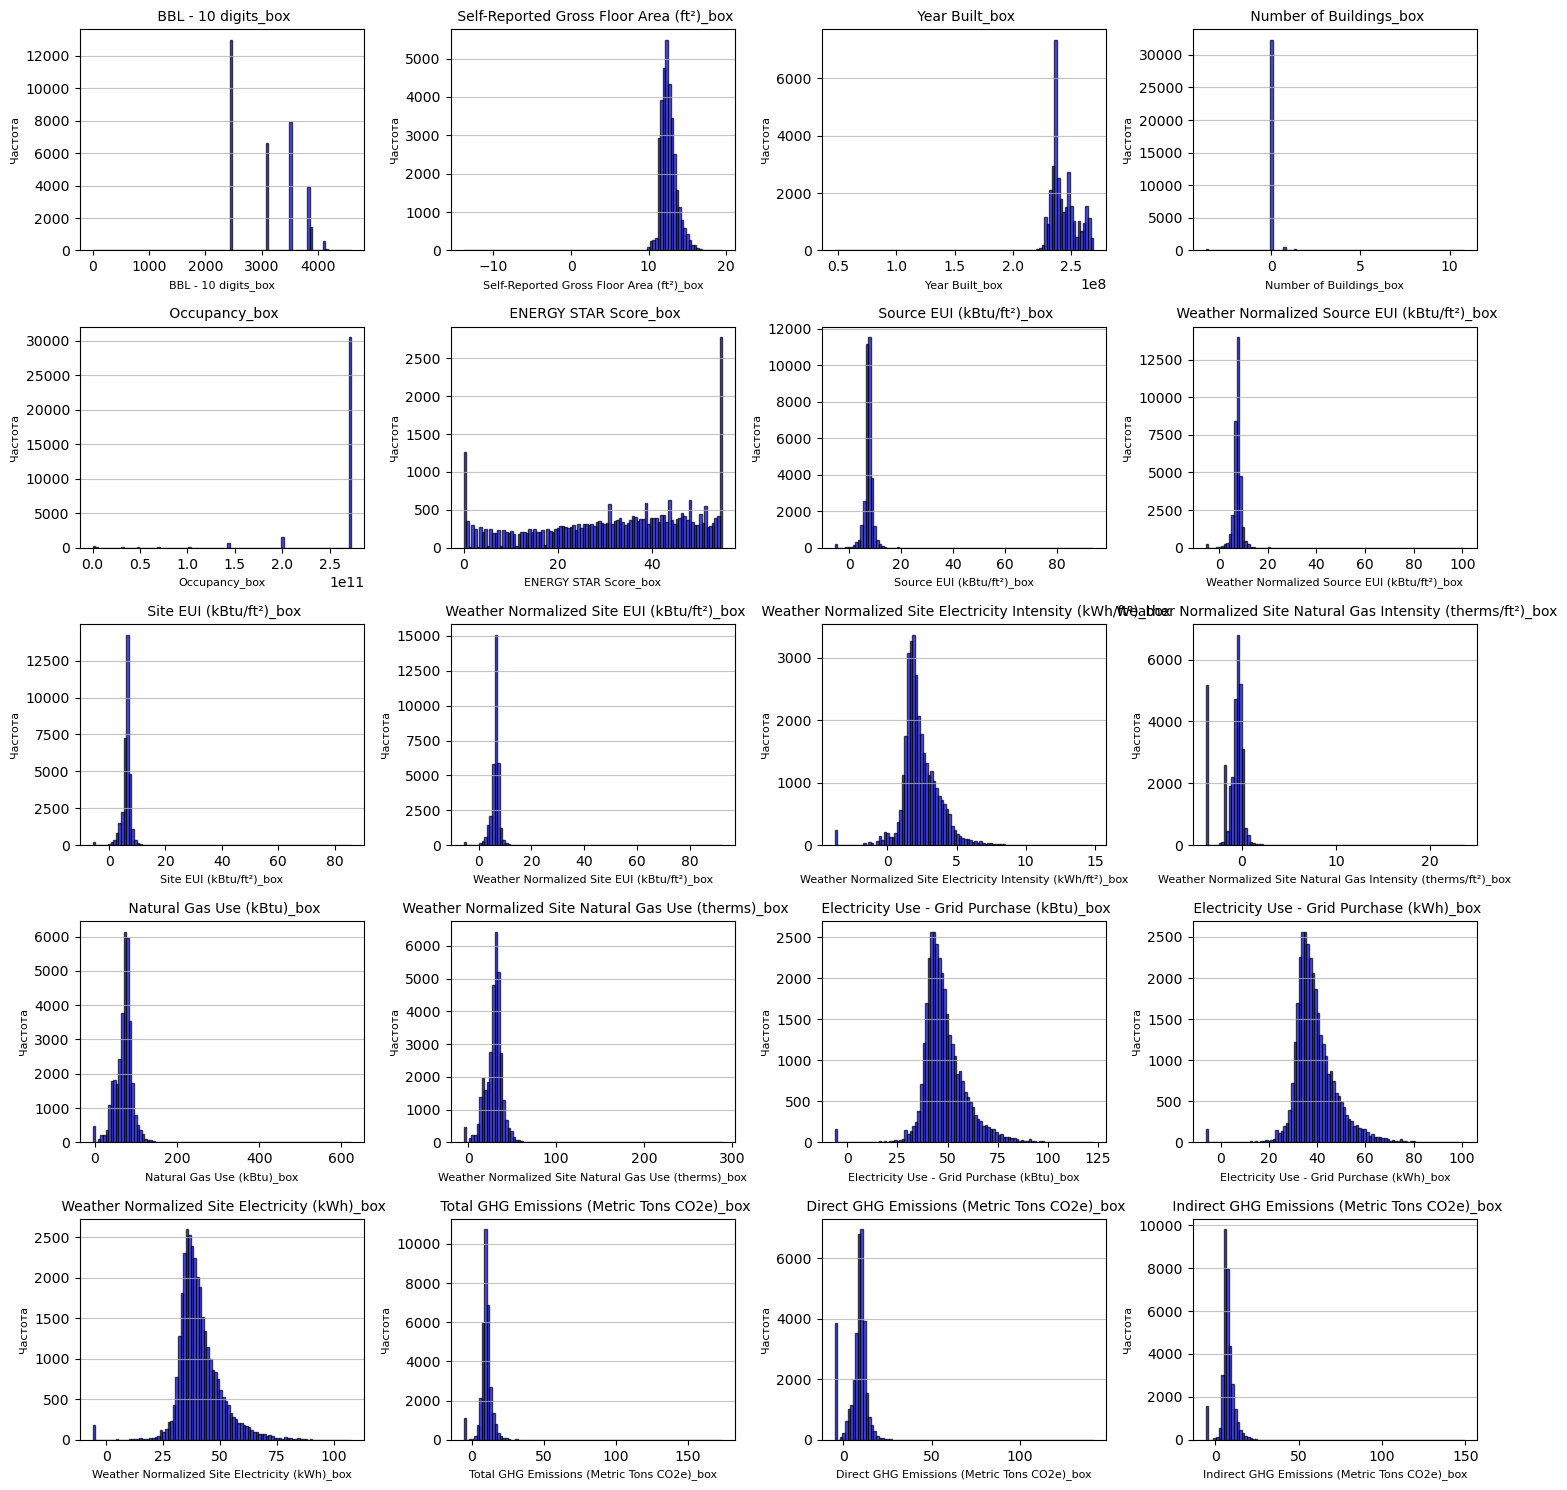

In [96]:
num_cols = len(range_scale_box)
n_cols = 4  # Количество графиков в строке
n_rows = (num_cols + n_cols - 1) // n_cols  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))  # Увеличенный размер фигуры

# Превращаем axes в одномерный массив для удобства
axes = axes.flatten()

# Построение гистограмм для каждого признака
for i, col in enumerate(range_scale_box):
    axes[i].hist(df_box[col], bins=100, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f' {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Частота', fontsize=8)
    axes[i].grid(axis='y', alpha=0.75)

# Убираем пустые подграфики, если они есть
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Настройка отступов
plt.tight_layout()
plt.show()

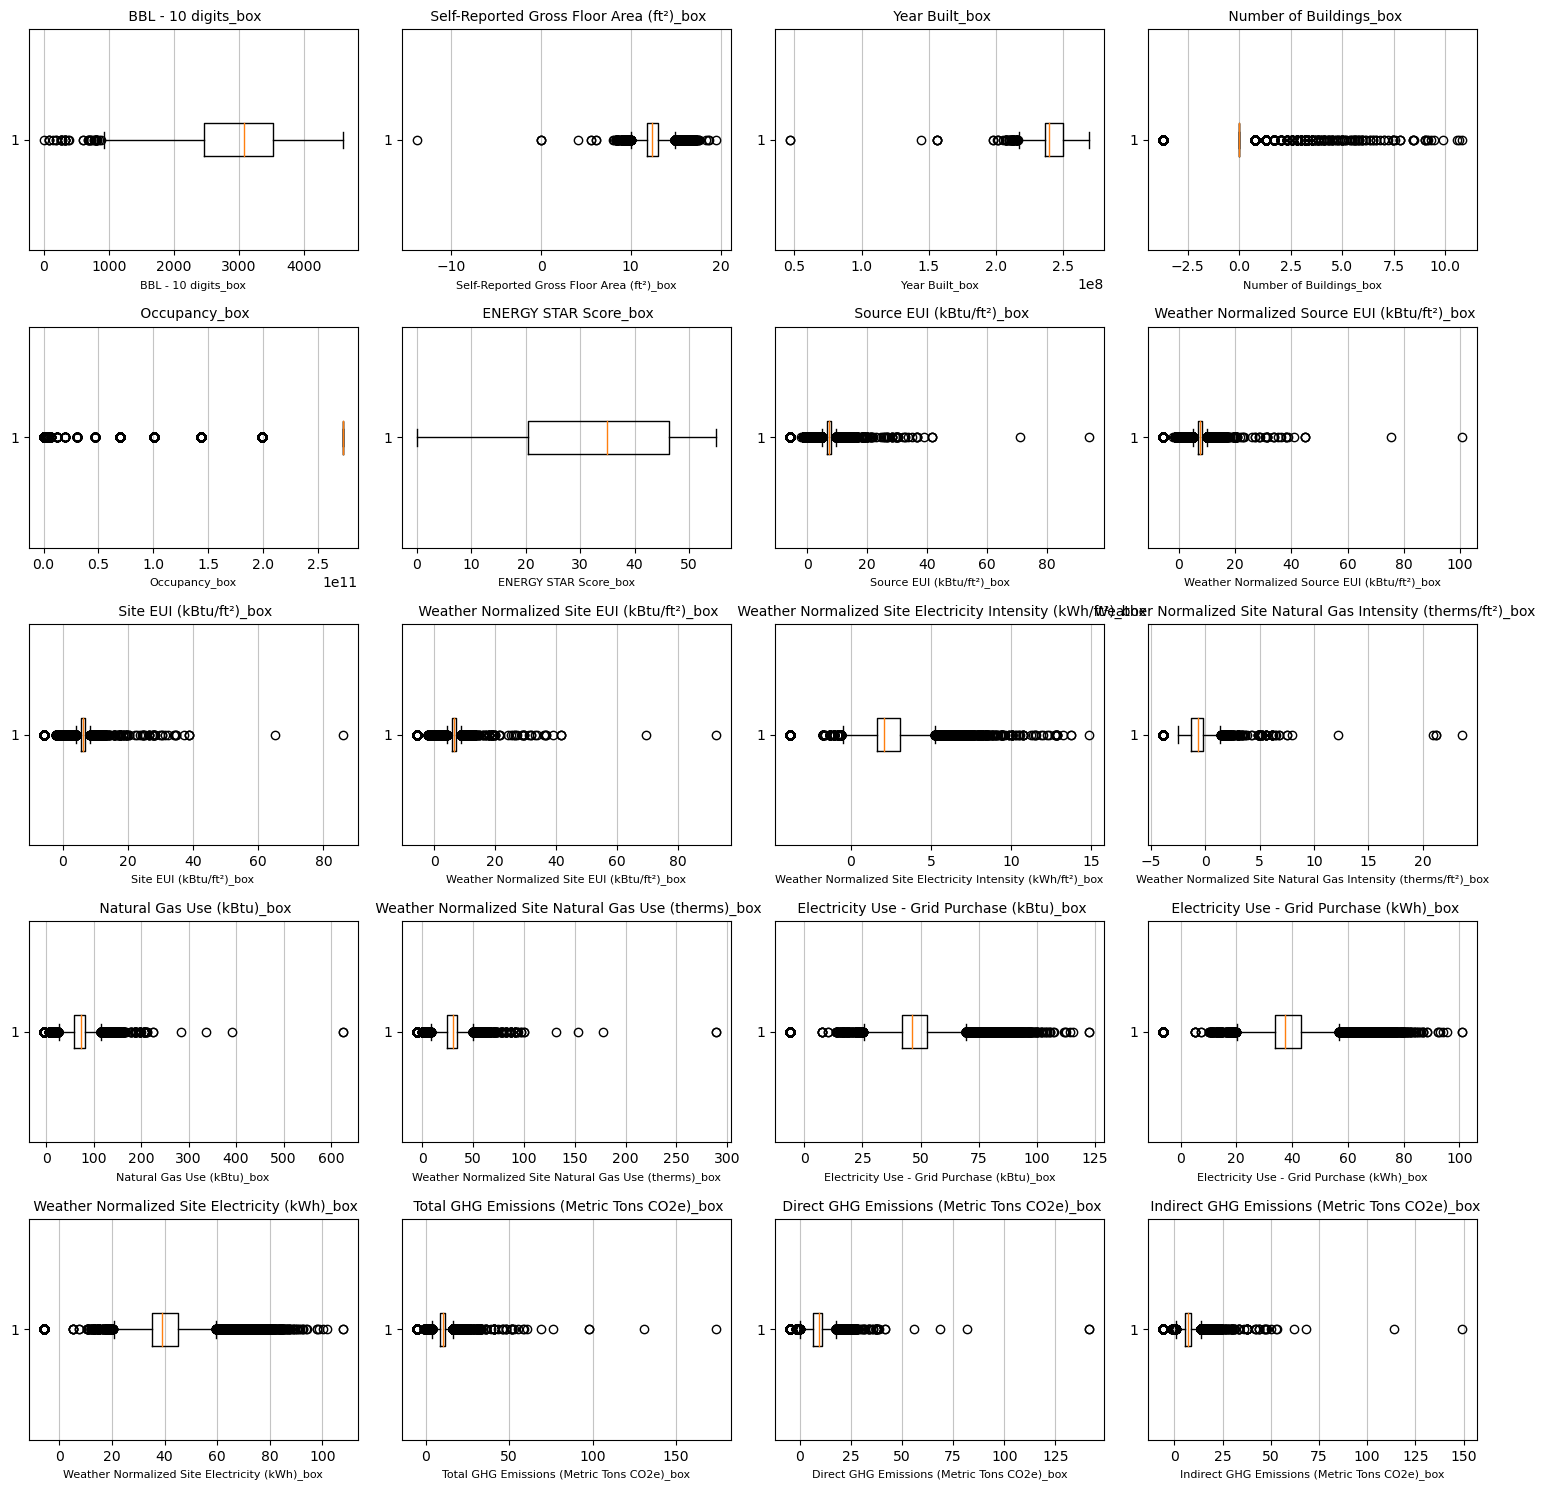

In [134]:
num_cols = len(range_scale_box)
n_cols = 4  # Количество графиков в строке
n_rows = (num_cols + n_cols - 1) // n_cols  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))  # Увеличенный размер фигуры

# Превращаем axes в одномерный массив для удобства
axes = axes.flatten()

# Построение боксплотов для каждого признака
for i, col in enumerate(range_scale_box):
    axes[i].boxplot(df_box[col], vert=False)  # Горизонтальный боксплот
    axes[i].set_title(f' {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].grid(axis='x', alpha=0.75)

# Убираем пустые подграфики, если они есть
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Настройка отступов
plt.tight_layout()
plt.show()

In [142]:
df_box.shape

(33623, 20)

In [105]:
df_no_outliers = pd.DataFrame()
for column in range_scale_box:
    Q1 = df_box[column].quantile(0.25)
    Q3 = df_box[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers[column] = df_box[(df_box[column] >= lower_bound) & (df_box[column] <= upper_bound)][column]
df_no_outliers = df_no_outliers.dropna()
df_no_outliers

,BBL - 10 digits_box,Self-Reported Gross Floor Area (ft²)_box,Year Built_box,Number of Buildings_box,Occupancy_box,ENERGY STAR Score_box,Source EUI (kBtu/ft²)_box,Weather Normalized Source EUI (kBtu/ft²)_box,Site EUI (kBtu/ft²)_box,Weather Normalized Site EUI (kBtu/ft²)_box,Weather Normalized Site Electricity Intensity (kWh/ft²)_box,Weather Normalized Site Natural Gas Intensity (therms/ft²)_box,Natural Gas Use (kBtu)_box,Weather Normalized Site Natural Gas Use (therms)_box,Electricity Use - Grid Purchase (kBtu)_box,Electricity Use - Grid Purchase (kWh)_box,Weather Normalized Site Electricity (kWh)_box,Total GHG Emissions (Metric Tons CO2e)_box,Direct GHG Emissions (Metric Tons CO2e)_box,Indirect GHG Emissions (Metric Tons CO2e)_box
1,3839.409,12.821,249250190.024,0.000,272549418103.235,54.920,5.204,5.405,4.405,4.623,0.759,-1.319,68.091,28.299,40.965,33.075,34.454,8.129,7.810,5.602
3,2458.711,12.033,259939303.658,0.000,272549418103.235,17.595,7.922,8.124,6.221,6.424,3.436,-0.817,66.643,27.550,49.808,40.449,42.214,9.394,7.524,8.033
5,3498.589,12.504,236528869.620,0.000,272549418103.235,40.359,5.855,7.200,4.951,6.665,1.415,-0.193,82.291,34.738,42.403,34.274,36.028,8.890,8.769,5.996
6,2461.151,13.333,261689765.366,0.000,272549418103.235,20.349,8.868,9.042,7.103,7.263,3.986,-1.740,67.009,27.366,62.112,50.704,52.999,13.915,7.595,13.057
8,3841.683,13.765,244851117.033,0.000,272549418103.235,23.255,6.831,7.019,5.106,5.296,2.709,-1.319,74.184,31.377,58.440,47.644,49.985,11.755,9.018,10.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33614,2464.631,11.983,241167099.670,0.000,272549418103.235,4.151,7.856,8.131,7.023,7.312,2.432,0.000,78.450,33.027,45.048,36.480,37.949,9.833,9.870,6.625
33616,3516.626,12.080,249250190.024,0.000,272549418103.235,26.526,7.411,7.639,6.916,7.146,1.179,0.000,80.822,33.859,39.482,31.839,33.025,9.748,10.347,5.115
33618,3513.579,11.516,238509769.533,0.000,272549418103.235,28.665,7.303,7.576,6.795,7.077,1.179,0.000,73.172,30.495,36.542,29.387,30.432,8.439,8.815,4.327
33619,3499.023,11.499,236528869.620,0.000,272549418103.235,35.933,7.246,7.519,6.771,7.049,1.034,0.000,72.950,30.385,35.723,28.704,29.710,8.361,8.771,4.107


In [106]:
data_loss = df_box.shape[0] - df_no_outliers.shape[0]
print(f'Мы снесли {data_loss} строк')

Мы снесли 14279 строк


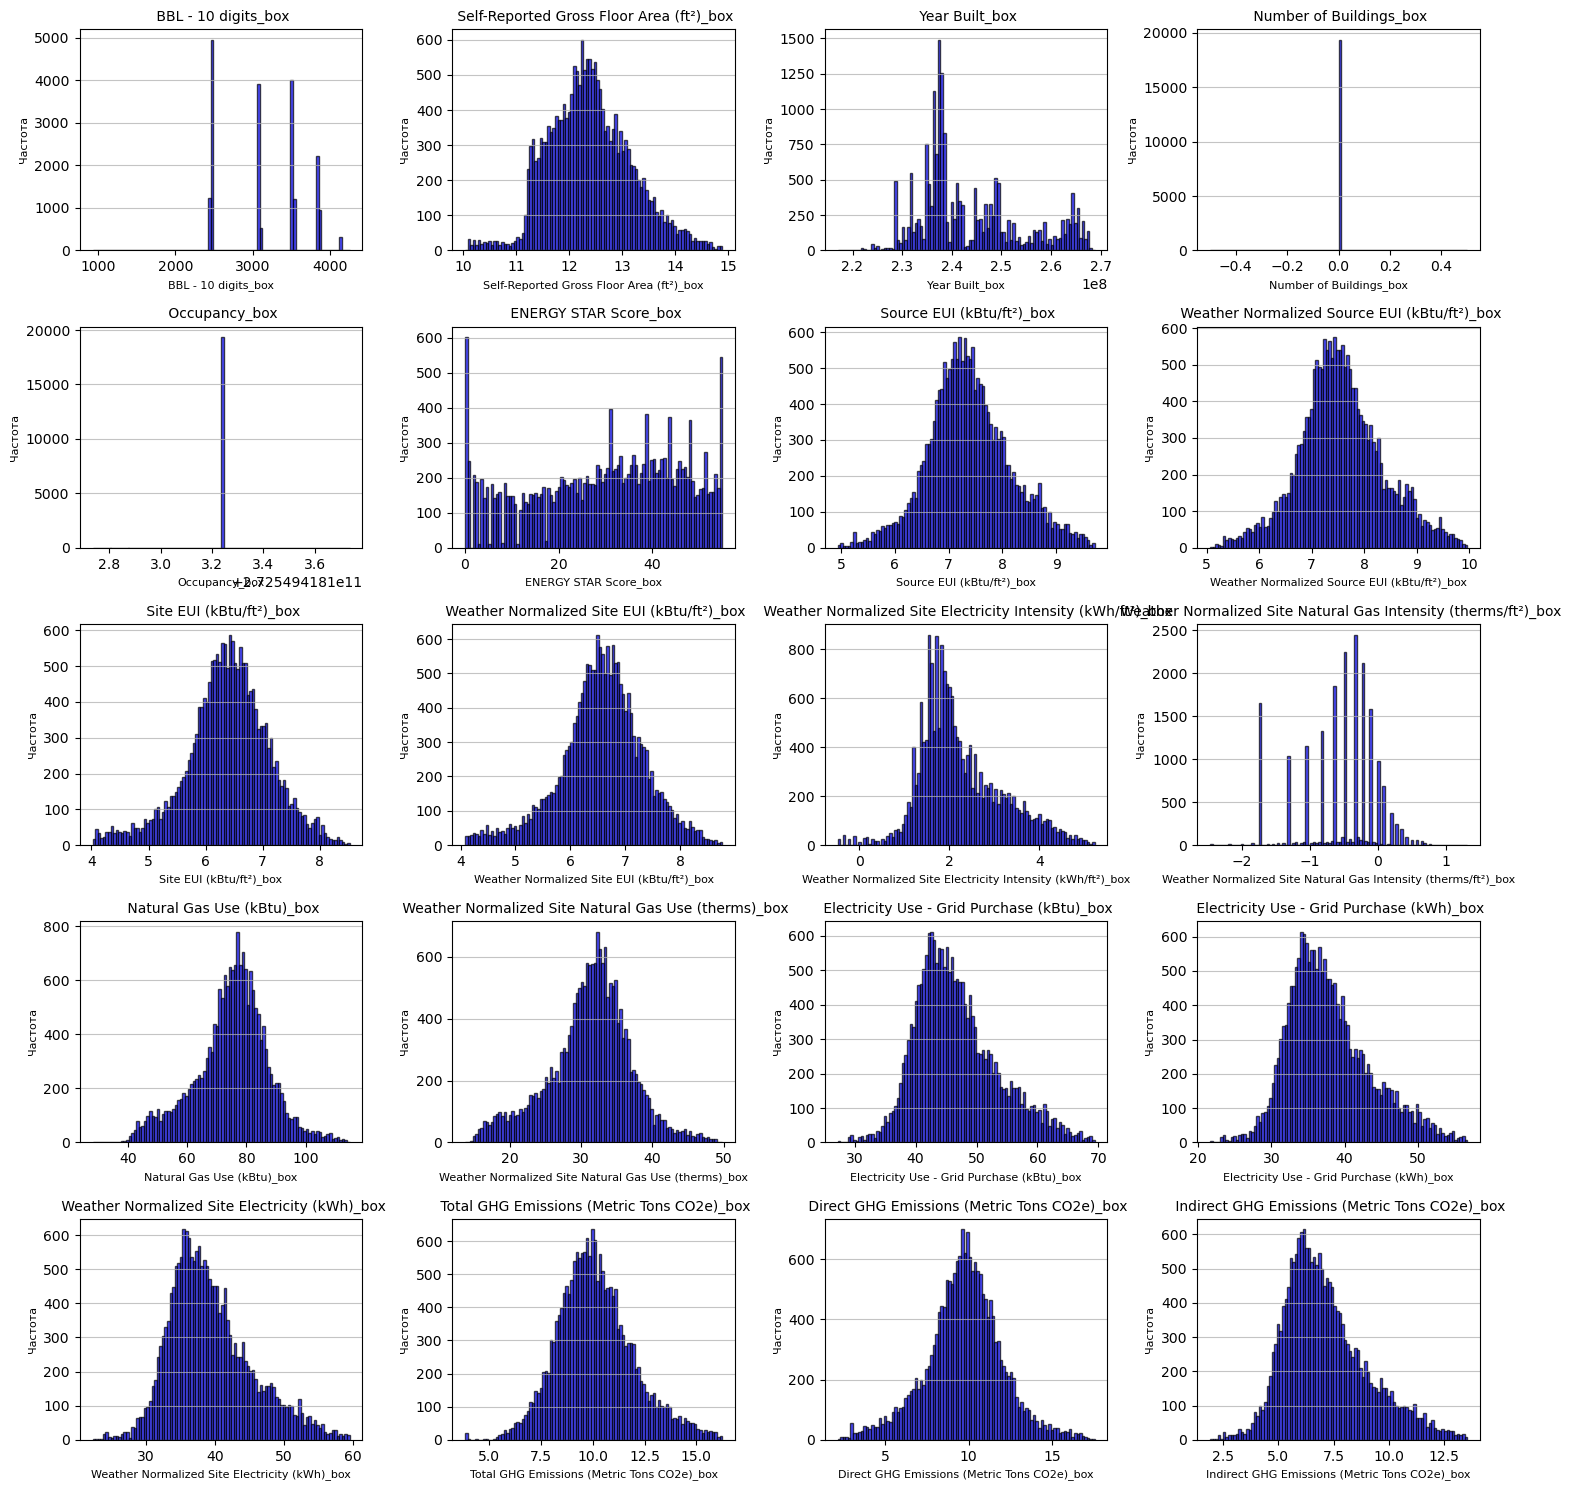

In [155]:
num_cols = len(range_scale_box)
n_cols = 4  # Количество графиков в строке
n_rows = (num_cols + n_cols - 1) // n_cols  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))  # Увеличенный размер фигуры

# Превращаем axes в одномерный массив для удобства
axes = axes.flatten()

# Построение гистограмм для каждого признака
for i, col in enumerate(range_scale_box):
    axes[i].hist(df_no_outliers[col], bins=100, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f' {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Частота', fontsize=8)
    axes[i].grid(axis='y', alpha=0.75)

# Убираем пустые подграфики, если они есть
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Настройка отступов
plt.tight_layout()
plt.show()

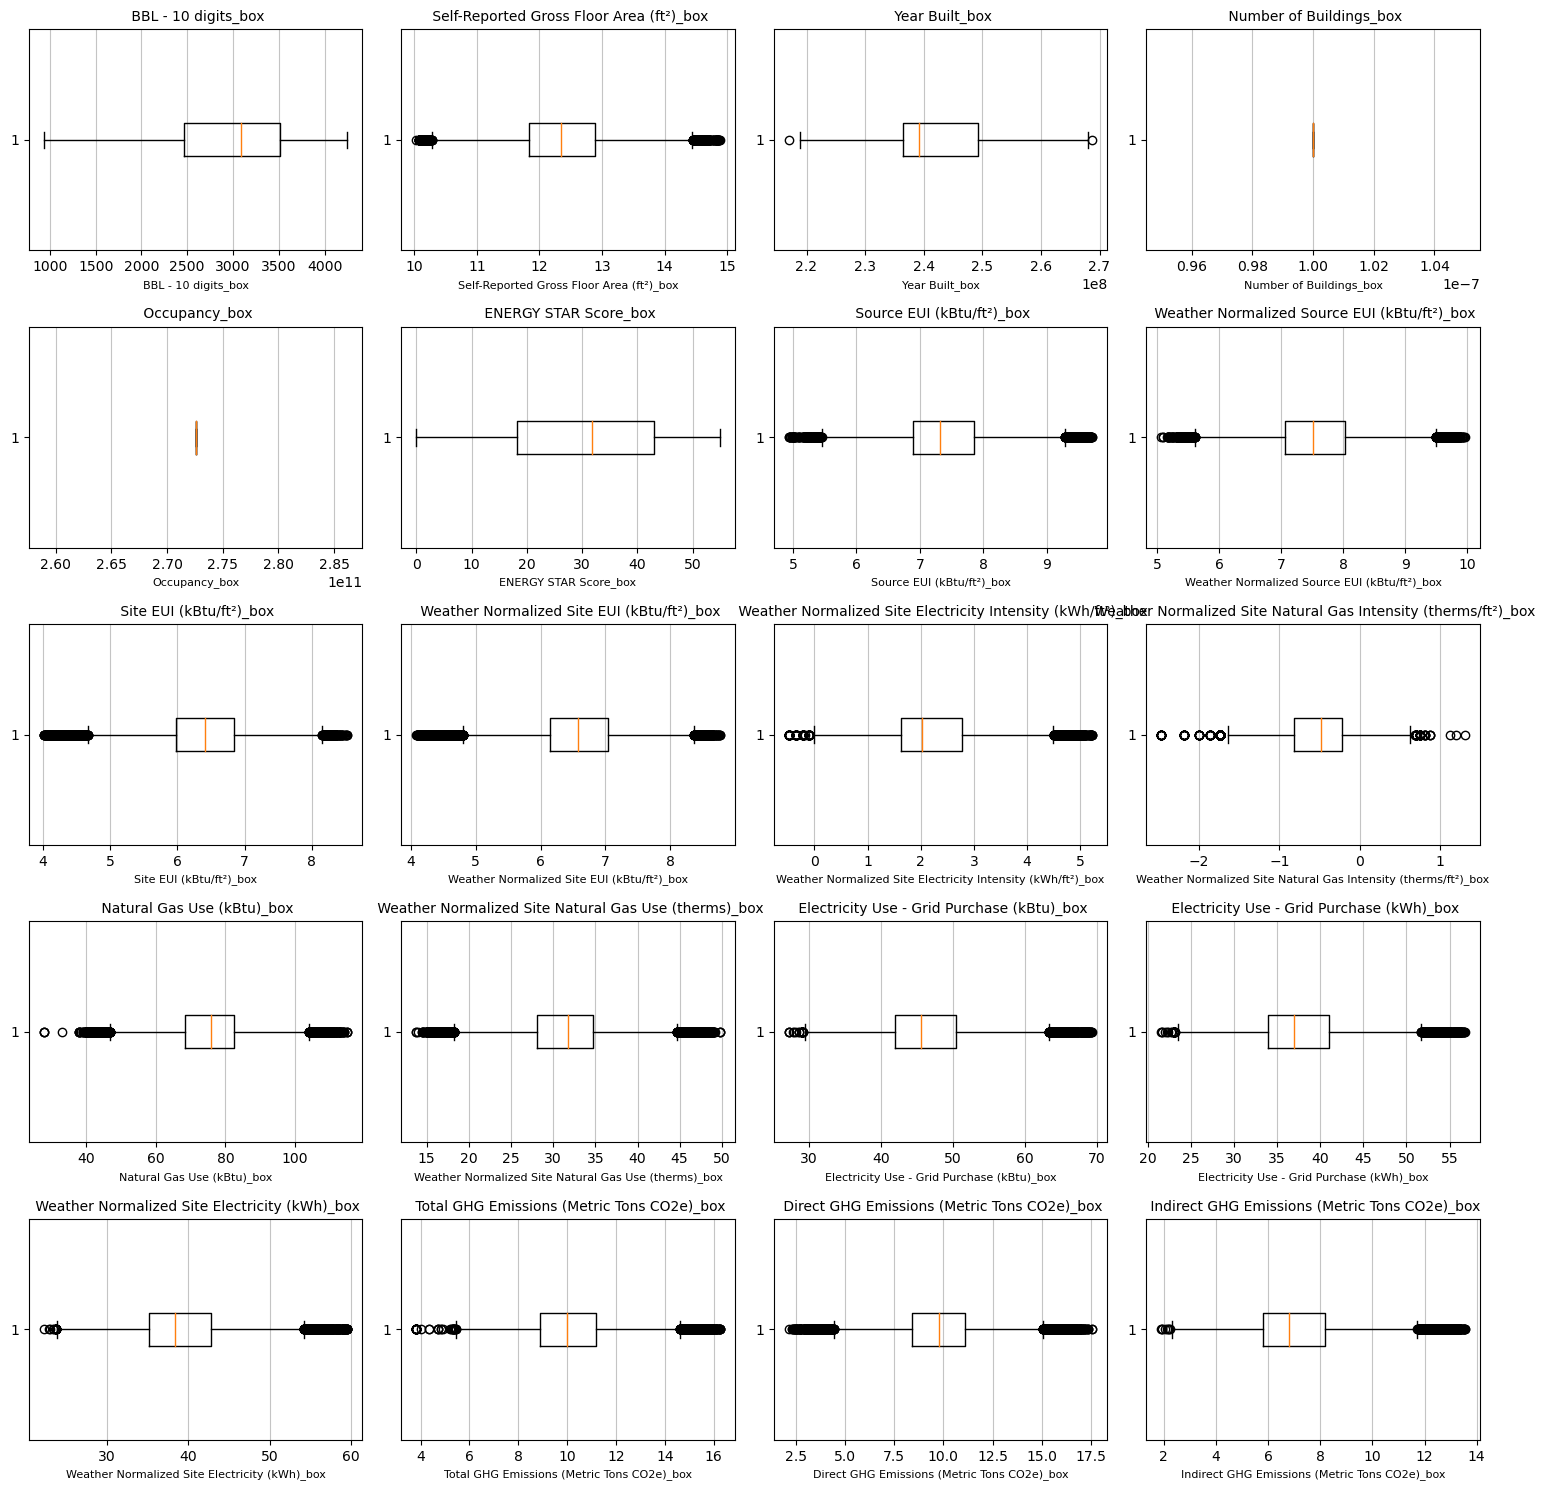

In [154]:
num_cols = len(range_scale_box)
n_cols = 4  # Количество графиков в строке
n_rows = (num_cols + n_cols - 1) // n_cols  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))  # Увеличенный размер фигуры

# Превращаем axes в одномерный массив для удобства
axes = axes.flatten()

# Построение боксплотов для каждого признака
for i, col in enumerate(range_scale_box):
    axes[i].boxplot(df_no_outliers[col], vert=False)  # Горизонтальный боксплот
    axes[i].set_title(f' {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].grid(axis='x', alpha=0.75)

# Убираем пустые подграфики, если они есть
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Настройка отступов
plt.tight_layout()
plt.show()

## Построение модели на очищенных данных (box-cox)

In [176]:
X_new = df_no_outliers.drop(columns = ['ENERGY STAR Score_box'])
y_new = df_no_outliers['ENERGY STAR Score_box']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split( 
    X_new,
    y_new,
    test_size=0.2,
    random_state=42)
scaler = StandardScaler()
#X_train_new = scaler.fit_transform(X_train_new) стандартизация никак не повлияла на качество метрик
#X_test_new = scaler.transform(X_test_new)

In [174]:
new_model = LinearRegression()
new_model.fit(X_train_new, y_train_new)
new_metrics = scores(new_model, X_train_new, y_train_new, X_test_new, y_test_new)
new_metrics

,Train,Test
MAE,9.043,9.105
MSE,129.488,132.444
RMSE,11.379,11.508
R2,0.477,0.468


Сравним с тем, что было

In [175]:
base_metrics

,Train,Test
MAE,32.011,32.032
MSE,1294.630,1300.100
RMSE,35.981,36.057
R2,0.036,0.035


Вау, мы крутые!